In [1]:
import numpy as np
import pylidc as pl
import pandas as pd
import matplotlib.pyplot as plt
from pylidc.utils import consensus
from skimage.measure import find_contours
import os
from scipy.ndimage import gaussian_filter
import seaborn as sns
from sklearn.ensemble import ExtraTreesClassifier
from scipy.stats.stats import pearsonr

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Standard plotly imports
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode

# Using plotly + cufflinks in offline mode
import cufflinks as cf
cf.go_offline(connected=True)
init_notebook_mode(connected=True)

import geopandas as gpd
import json
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, CategoricalColorMapper
from bokeh.palettes import brewer
from fuzzywuzzy import process

from maps import slider_map, match_names, replace_names

C:\Users\ruben\Anaconda3\envs\ada\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning:

Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning



# Analysing medical data to help improve society's quality of life

How can we use medical data to help improve society's quality of life?<br>
There is endless types of medical data out there for different diseases, which data should we use in order to help as many people as possible?<br>

To explore this question, we have subdivided it into some more specific areas that can gain us different types of information. They are shown in this scheme.

![title](Images/scheme.png)

# 1. Which diseases have the most significant negative impact on society's quality of life as of today? How does differ between countries and over time?
The ***prevelance*** of the disease alone is not enough to quantify this, take herpes for example. The herpes simplex virus is one of the most common diseases on earth. It is estimated that well over 50% of the world population is infected with the virus. However, most people are completely unaware that they are and show little to no symptoms while others do have severe symptoms. There is no cure and once you are infected, the virus will most likely stay in your body for the rest of your life.<br> 
***Conclusion:*** quality of life is only significantly effected if the disease causes pain or limits the patient ablilities.

The most severe effect of a disease is when it causes death, after all, you can't have any "quality of life" anymore if your life has come to an end. <br> 
***Conclusion:*** If we want to have a big impact on society's quality of life it might be interesting to look at the diseases that cause the most deaths.

## 1.1 Most common causes of death

We start by loading data from the GBD dataset, which contains the number of deaths from different causes, for different countries, from the year 1990 to 2017.

In [4]:
data=pd.read_csv("data/annual-number-of-deaths-by-cause.csv" )
print(data.shape)
data.head(5)

(6686, 36)


Entity Code  Year  Dementia  Cardiovascular diseases  Kidney disease  \
0  Afghanistan  AFG  1990     856.0                  28372.0          2708.0   
1  Afghanistan  AFG  1991     908.0                  30368.0          2851.0   
2  Afghanistan  AFG  1992     970.0                  33035.0          3057.0   
3  Afghanistan  AFG  1993    1066.0                  36512.0          3329.0   
4  Afghanistan  AFG  1994    1161.0                  40285.0          3641.0   

   Respiratory disease  Liver disease  Diabetes, blood and endocrine disease  \
0               3394.0         1349.0                                 6177.0   
1               3641.0         1443.0                                 6522.0   
2               3967.0         1572.0                                 7009.0   
3               4398.0         1735.0                                 7655.0   
4               4870.0         1911.0                                 8377.0   

   Digestive disease  ...  Heat-related deaths (hot or cold exposure)  \
0             1708.0  ...                                       222.0   
1             1792.0  ...                                       230.0   
2             1911.0  ...                                       250.0   
3             2071.0  ...                                       289.0   
4             2243.0  ...                                       315.0   

   Nutritional deficiencies  Suicide  Execution  Meningitis (deaths)  \
0                     567.0    703.0        NaN          6469.977091   
1                     588.0    754.0        NaN          6347.158764   
2                     623.0    820.0        NaN          6659.741428   
3                     674.0    894.0        NaN          8068.386263   
4                     731.0    977.0        NaN          9432.845127   

   Lower respiratory infections (deaths)  \
0                           22836.912346   
1                           22325.633931   
2                           23205.280750   
3                           28229.715397   
4                           32652.297630   

   Intestinal infectious diseases (deaths)  \
0                               295.382207   
1                               303.866598   
2                               317.750121   
3                               333.978331   
4                               348.419085   

   Protein-energy malnutrition (deaths)  Conflict (deaths)  Terrorism (deaths)  
0                           1607.703797             1508.0                12.0  
1                           1558.132316             3498.0                68.0  
2                           1617.721576             4341.0                49.0  
3                           1931.808553                NaN                 NaN  
4                           2351.629206             9090.0                22.0  

[5 rows x 36 columns]

In [5]:
# One of the entities is "world" which contains the summations over all countries. 
# Let's see which diseases are most prevalent world wide
df = data[data["Entity"]=='World'].iloc[:,2:].sort_values(6572, ascending=False, axis=1)

Text(0.5, 1.0, 'Amount of recorded deaths 1990-2017')

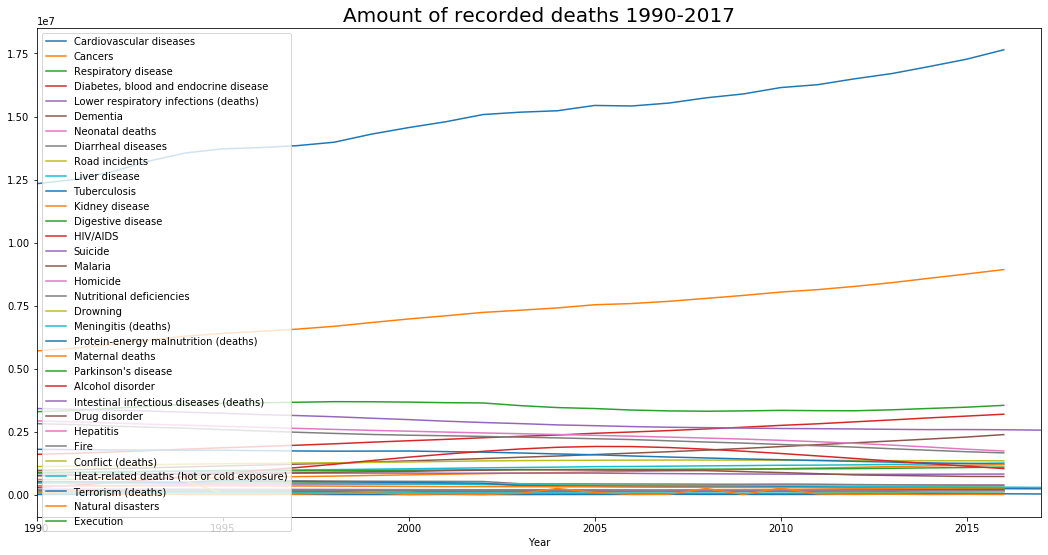

In [6]:
df.plot(x='Year', figsize=(18,9))
plt.title('Amount of recorded deaths 1990-2017', fontsize=20)

**TODO: maybe cleanup the plot above a little bit? (legend should not overlap with x-axis**

It is clear that cardiovascular disease is by far the most common cause of death, followed by cancer, respiratory disease, ... <br> Note that cardiovascular diease is also the faster growing cause of death!

### 1.1.1 Difference between countries

Lets normalize this dataframe to obtain a ratio and not a strict number of deaths, to be able to compare between different countries.

In [7]:
# Copy the df 
normalized = data.copy()

In [8]:
# Check the type of the values, to see if any problems. 
normalized.dtypes

Entity                                         object
Code                                           object
Year                                            int64
Dementia                                      float64
Cardiovascular diseases                       float64
Kidney disease                                float64
Respiratory disease                           float64
Liver disease                                 float64
Diabetes, blood and endocrine disease         float64
Digestive disease                             float64
Hepatitis                                     float64
Cancers                                       float64
Parkinson's disease                           float64
Fire                                          float64
Malaria                                       float64
Drowning                                      float64
Homicide                                      float64
HIV/AIDS                                      float64
Drug disorder               

We see that Execution are not floats but object. Lets remove this column before computing the total

In [9]:
# remove the execution.
normalized = normalized.drop('Execution', 1)

# Take the colums to take into account 
column = normalized.columns.to_list()[3:]

# Compute the total 
normalized['Total'] = normalized[column].sum(axis = 1)


In [10]:
normalized.loc[ :, "Dementia" : "Terrorism (deaths)"] = normalized.loc[ :, "Dementia" : "Terrorism (deaths)"].fillna(0).div(normalized['Total'], axis = 0)

In [11]:
normalized

Entity Code  Year  Dementia  Cardiovascular diseases  \
0     Afghanistan  AFG  1990  0.006708                 0.222322   
1     Afghanistan  AFG  1991  0.006677                 0.223322   
2     Afghanistan  AFG  1992  0.006691                 0.227871   
3     Afghanistan  AFG  1993  0.006752                 0.231256   
4     Afghanistan  AFG  1994  0.006331                 0.219681   
...           ...  ...   ...       ...                      ...   
6681     Zimbabwe  ZWE  2013  0.009296                 0.099218   
6682     Zimbabwe  ZWE  2014  0.010014                 0.105632   
6683     Zimbabwe  ZWE  2015  0.010744                 0.110023   
6684     Zimbabwe  ZWE  2016  0.011585                 0.114236   
6685     Zimbabwe  ZWE  2017  0.000000                 0.000000   

      Kidney disease  Respiratory disease  Liver disease  \
0           0.021220             0.026595       0.010571   
1           0.020966             0.026775       0.010612   
2           0.021087             0.027364       0.010843   
3           0.021085             0.027856       0.010989   
4           0.019855             0.026557       0.010421   
...              ...                  ...            ...   
6681        0.011727             0.021369       0.006827   
6682        0.012613             0.022560       0.007204   
6683        0.013356             0.023452       0.007553   
6684        0.014016             0.024233       0.007862   
6685        0.000000             0.000000       0.000000   

      Diabetes, blood and endocrine disease  Digestive disease  ...  \
0                                  0.048403           0.013384  ...   
1                                  0.047962           0.013178  ...   
2                                  0.048347           0.013182  ...   
3                                  0.048484           0.013117  ...   
4                                  0.045681           0.012231  ...   
...                                     ...                ...  ...   
6681                               0.044394           0.021123  ...   
6682                               0.048202           0.022462  ...   
6683                               0.051376           0.023479  ...   
6684                               0.054342           0.024466  ...   
6685                               0.000000           0.000000  ...   

      Heat-related deaths (hot or cold exposure)  Nutritional deficiencies  \
0                                       0.001740                  0.004443   
1                                       0.001691                  0.004324   
2                                       0.001724                  0.004297   
3                                       0.001830                  0.004269   
4                                       0.001718                  0.003986   
...                                          ...                       ...   
6681                                    0.000743                  0.019341   
6682                                    0.000759                  0.020977   
6683                                    0.000882                  0.021936   
6684                                    0.000907                  0.023261   
6685                                    0.000000                  0.000000   

       Suicide  Meningitis (deaths)  Lower respiratory infections (deaths)  \
0     0.005509             0.050698                               0.178949   
1     0.005545             0.046676                               0.164180   
2     0.005656             0.045938                               0.160067   
3     0.005662             0.051103                               0.178798   
4     0.005328             0.051439                               0.178059   
...        ...                  ...                                    ...   
6681  0.012804             0.011463                               0.082555   
6682  0.013708             0.011676                               0.084

We will use Plotly to plot interactive plots as our data vary in term of country and years, it will be easier like this. 


**TODO: for one country: look at evolution of one disease over time, look at different diseases in one year; for one year: look at different countries for one disease**

In [12]:
# Set year to 0 to plot over all years
@interact
def scatter_plot(x=list(normalized.select_dtypes('number').columns), 
                 y=list(normalized.select_dtypes('number').columns)[1:],
                 year = list(np.append(normalized.Year.unique(),[0])),
                 country = list(np.append(normalized.Entity.unique(),["All"])),
                 theme =list(cf.themes.THEMES.keys()), 
                 colorscale=list(cf.colors._scales_names.keys())):
    norm = normalized
    if country != "All" : 
                        norm = norm[norm['Entity']==country] 
    if year != 0 : 
                    norm = norm[norm['Year']==year] 
                
    norm.iplot(kind='scatter', x=x, y=y, mode='markers', 
             xTitle=x.title(), yTitle=y.title(), 
             text='Entity',
             title=f'{y.title()} vs {x.title()}',
            theme=theme, colorscale=colorscale)

interactive(children=(Dropdown(description='x', options=('Year', 'Dementia', 'Cardiovascular diseases', 'Kidne…

### 1.1.2 Evolution over time

Let's look at how the prevalence and number of deaths of different diseases have changed over the years in different countries.

In [13]:
disease_change = normalized.copy()
disease_change[(disease_change.Year == 2017) | (disease_change.Year == 1990)].head()

Entity Code  Year  Dementia  Cardiovascular diseases  Kidney disease  \
0   Afghanistan  AFG  1990  0.006708                 0.222322        0.021220   
27  Afghanistan  AFG  2017  0.000000                 0.000000        0.000000   
28      Albania  ALB  1990  0.027091                 0.436518        0.016956   
55      Albania  ALB  2017  0.000000                 0.000000        0.000000   
56      Algeria  DZA  1990  0.030877                 0.340893        0.028245   

    Respiratory disease  Liver disease  Diabetes, blood and endocrine disease  \
0              0.026595       0.010571                               0.048403   
27             0.000000       0.000000                               0.000000   
28             0.049401       0.014597                               0.034485   
55             0.000000       0.000000                               0.000000   
56             0.032202       0.015781                               0.063774   

    Digestive disease  ...  Heat-related deaths (hot or cold exposure)  \
0            0.013384  ...                                    0.001740   
27           0.000000  ...                                    0.000000   
28           0.015617  ...                                    0.000319   
55           0.000000  ...                                    0.000000   
56           0.014353  ...                                    0.001137   

    Nutritional deficiencies   Suicide  Meningitis (deaths)  \
0                   0.004443  0.005509             0.050698   
27                  0.000000  0.000000             0.185693   
28                  0.002486  0.008095             0.006542   
55                  0.000000  0.000000             0.046112   
56                  0.002293  0.007576             0.006870   

    Lower respiratory infections (deaths)  \
0                                0.178949   
27                               0.604008   
28                               0.124942   
55                               0.945815   
56                               0.058068   

    Intestinal infectious diseases (deaths)  \
0                                  0.002315   
27                                 0.000000   
28                                 0.000013   
55                                 0.000000   
56                                 0.002391   

    Protein-energy malnutrition (deaths)  Conflict (deaths)  \
0                               0.012598           0.011817   
27                              0.038604           0.000000   
28                              0.002097           0.000000   
55                              0.008073           0.000000   
56                              0.002388           0.000000   

    Terrorism (deaths)          Total  
0             0.000094  127616.975442  
27            0.171695   35481.574656  
28            0.000000   15687.796748  
55            0.000000     403.517623  
56            0.000028  106391.285455  

[5 rows x 36 columns]

We see that for 2017, only the columns with (deaths) in their name have values. To be able to compare better, we use the data from 2016.

In [14]:
disease_change = normalized.copy()
disease_change[(disease_change.Year == 2016) | (disease_change.Year == 1990)].head()

Entity Code  Year  Dementia  Cardiovascular diseases  Kidney disease  \
0   Afghanistan  AFG  1990  0.006708                 0.222322        0.021220   
26  Afghanistan  AFG  2016  0.010281                 0.284500        0.028502   
28      Albania  ALB  1990  0.027091                 0.436518        0.016956   
54      Albania  ALB  2016  0.043395                 0.588953        0.017666   
56      Algeria  DZA  1990  0.030877                 0.340893        0.028245   

    Respiratory disease  Liver disease  Diabetes, blood and endocrine disease  \
0              0.026595       0.010571                               0.048403   
26             0.035139       0.014471                               0.075834   
28             0.049401       0.014597                               0.034485   
54             0.034743       0.013952                               0.031119   
56             0.032202       0.015781                               0.063774   

    Digestive disease  ...  Heat-related deaths (hot or cold exposure)  \
0            0.013384  ...                                    0.001740   
26           0.014446  ...                                    0.001583   
28           0.015617  ...                                    0.000319   
54           0.008471  ...                                    0.000226   
56           0.014353  ...                                    0.001137   

    Nutritional deficiencies   Suicide  Meningitis (deaths)  \
0                   0.004443  0.005509             0.050698   
26                  0.002252  0.007961             0.023632   
28                  0.002486  0.008095             0.006542   
54                  0.000226  0.008199             0.000851   
56                  0.002293  0.007576             0.006870   

    Lower respiratory infections (deaths)  \
0                                0.178949   
26                               0.075644   
28                               0.124942   
54                               0.016860   
56                               0.058068   

    Intestinal infectious diseases (deaths)  \
0                                  0.002315   
26                                 0.001544   
28                                 0.000013   
54                                 0.000008   
56                                 0.002391   

    Protein-energy malnutrition (deaths)  Conflict (deaths)  \
0                               0.012598           0.011817   
26                              0.004831           0.058442   
28                              0.002097           0.000000   
54                              0.000149           0.000000   
56                              0.002388           0.000000   

    Terrorism (deaths)          Total  
0             0.000094  127616.975442  
26            0.021752  282365.961232  
28            0.000000   15687.796748  
54            0.000000   22076.459184  
56            0.000028  106391.285455  

[5 rows x 36 columns]

Now we can compute the difference between 2016 and 1990.

In [15]:
diseases = normalized.columns.tolist()[3:35]

# Create a new dataframe, start with the country names and codes to be able to plot this on a map later
diseases_change = normalized[['Entity', 'Code']].drop_duplicates().set_index('Entity')

for disease in diseases:
    # Compute the difference between the mortality rates of 2016 and 1990 for every disease in every country
    diseases_change[disease] = normalized.groupby('Entity')[disease].apply(lambda x : x.tail(2).values[0] - x.head(1).values[0])
    
diseases_change

Code  Dementia  Cardiovascular diseases  \
Entity                                                              
Afghanistan                AFG  0.003573                 0.062178   
Albania                    ALB  0.016304                 0.152436   
Algeria                    DZA  0.038049                 0.075853   
American Samoa             ASM  0.000573                -0.027112   
Andean Latin America       NaN  0.000000                 0.000000   
...                        ...       ...                      ...   
Yemen                      YEM  0.006957                 0.067893   
Yugoslavia            OWID_YGS       NaN                      NaN   
Zaire                      NaN  0.000000                 0.000000   
Zambia                     ZMB  0.004232                 0.064136   
Zimbabwe                   ZWE  0.003309                -0.011435   

                      Kidney disease  Respiratory disease  Liver disease  \
Entity                                                                     
Afghanistan                 0.007282             0.008544       0.003900   
Albania                     0.000710            -0.014659      -0.000646   
Algeria                     0.015568             0.003399       0.006555   
American Samoa              0.015784            -0.018775       0.003857   
Andean Latin America        0.000000             0.000000       0.000000   
...                              ...                  ...            ...   
Yemen                       0.006958             0.003648       0.003503   
Yugoslavia                       NaN                  NaN            NaN   
Zaire                       0.000000             0.000000       0.000000   
Zambia                      0.003352             0.008052       0.011949   
Zimbabwe                    0.006635            -0.001630      -0.005295   

                      Diabetes, blood and endocrine disease  \
Entity                                                        
Afghanistan                                        0.027432   
Albania                                           -0.003366   
Algeria                                            0.042640   
American Samoa                                     0.074988   
Andean Latin America                               0.000000   
...                                                     ...   
Yemen                                              0.017656   
Yugoslavia                                              NaN   
Zaire                                              0.000000   
Zambia                                             0.014846   
Zimbabwe                                           0.027392   

                      Digestive disease  Hepatitis   Cancers  ...  \
Entity                                                        ...   
Afghanistan                    0.001062  -0.000392  0.020200  ...   
Albania                       -0.007147  -0.001649  0.036469  ...   
Algeria                        0.000103  -0.000953  0.026060  ...   
American Samoa                -0.005282   0.000000  0.032714  ...   
Andean Latin America           0.000000   0.000000  0.000000  ...   
...                                 ...        ...       ...  ...   
Yemen                         -0.001037  -0.000599  0.032421  ...   
Yugoslavia                          NaN        NaN       NaN  ...   
Zaire                          0.000000   0.000000  0.000000  ...   
Zambia                         0.010180   0.001123  0.033790  ...   
Zimbabwe                       0.011037   0.000267  0.004166  ...   

                      Diarrheal diseases  \
Entity                                     
Afghanistan                    -0.014331   
Albania                        -0.005739   
Algeria                        -0.009130   
American Samoa                 -0.006212   
Andean Latin America            0.000000   
...                                  ...   
Yemen                          -0.122561   
Yugoslavia               

Let us zoom in on cardiovascular diseases and visualise this. First, we saw that this difference could not be computed for every country, so let's drop those who generated a NaN.

In [16]:
diseases_change = diseases_change.dropna(subset=['Cardiovascular diseases'])
diseases_change

Code  Dementia  Cardiovascular diseases  \
Entity                                                              
Afghanistan                AFG  0.003573                 0.062178   
Albania                    ALB  0.016304                 0.152436   
Algeria                    DZA  0.038049                 0.075853   
American Samoa             ASM  0.000573                -0.027112   
Andean Latin America       NaN  0.000000                 0.000000   
...                        ...       ...                      ...   
World                 OWID_WRL  0.022793                 0.049485   
Yemen                      YEM  0.006957                 0.067893   
Zaire                      NaN  0.000000                 0.000000   
Zambia                     ZMB  0.004232                 0.064136   
Zimbabwe                   ZWE  0.003309                -0.011435   

                      Kidney disease  Respiratory disease  Liver disease  \
Entity                                                                     
Afghanistan                 0.007282             0.008544       0.003900   
Albania                     0.000710            -0.014659      -0.000646   
Algeria                     0.015568             0.003399       0.006555   
American Samoa              0.015784            -0.018775       0.003857   
Andean Latin America        0.000000             0.000000       0.000000   
...                              ...                  ...            ...   
World                       0.008582            -0.008640       0.004259   
Yemen                       0.006958             0.003648       0.003503   
Zaire                       0.000000             0.000000       0.000000   
Zambia                      0.003352             0.008052       0.011949   
Zimbabwe                    0.006635            -0.001630      -0.005295   

                      Diabetes, blood and endocrine disease  \
Entity                                                        
Afghanistan                                        0.027432   
Albania                                           -0.003366   
Algeria                                            0.042640   
American Samoa                                     0.074988   
Andean Latin America                               0.000000   
...                                                     ...   
World                                              0.023363   
Yemen                                              0.017656   
Zaire                                              0.000000   
Zambia                                             0.014846   
Zimbabwe                                           0.027392   

                      Digestive disease  Hepatitis   Cancers  ...  \
Entity                                                        ...   
Afghanistan                    0.001062  -0.000392  0.020200  ...   
Albania                       -0.007147  -0.001649  0.036469  ...   
Algeria                        0.000103  -0.000953  0.026060  ...   
American Samoa                -0.005282   0.000000  0.032714  ...   
Andean Latin America           0.000000   0.000000  0.000000  ...   
...                                 ...        ...       ...  ...   
World                          0.000276  -0.001155  0.037360  ...   
Yemen                         -0.001037  -0.000599  0.032421  ...   
Zaire                          0.000000   0.000000  0.000000  ...   
Zambia                         0.010180   0.001123  0.033790  ...   
Zimbabwe                       0.011037   0.000267  0.004166  ...   

                      Diarrheal diseases  \
Entity                                     
Afghanistan                    -0.014331   
Albania                        -0.005739   
Algeria                        -0.009130   
American Samoa                 -0.006212   
Andean Latin America            0.000000   
...                                  ...   
World                          -0.033195   
Yemen                    

Let's visualise this data on a map.

Inspiration for this code and source for the shapefile: https://towardsdatascience.com/a-complete-guide-to-an-interactive-geographical-map-using-python-f4c5197e23e0

**TODO: redo to plotly, interactive?**

In [17]:
shapefile = 'data/countries_110m/ne_110m_admin_0_countries.shp'

gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]
gdf.columns = ['country', 'country_code', 'geometry']
gdf.head()

country country_code  \
0                         Fiji          FJI   
1  United Republic of Tanzania          TZA   
2               Western Sahara          SAH   
3                       Canada          CAN   
4     United States of America          USA   

                                            geometry  
0  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
2  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
3  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
4  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...

In [18]:
diseases_changed_map = gdf.merge(diseases_change, left_on = 'country_code', right_on = 'Code', how = 'left')

In [19]:
#Read data to json
diseases_changed_map_json = json.loads(diseases_changed_map.to_json())

#Convert to str like object
diseases_changed_map_json_data = json.dumps(diseases_changed_map_json)

In [20]:
#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = diseases_changed_map_json_data)

#Define a sequential multi-hue color palette.
palette = brewer['PuOr'][7]

#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = -0.2, high = 0.2)

#Define custom tick labels for color bar.
tick_labels = {'0': '0', '1': '1', '2':'2', '3':'3', '4':'4', '5':'5', '6':'6','7':'7'}

#Create color bar. 
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=7,width = 500, height = 20,
border_line_color=None,location = (0,0), orientation = 'horizontal', major_label_overrides = tick_labels)

#Create figure object.
p = figure(title = 'Change between 1990 and 2016 in proportion of total deaths by cardiovascular diseases', plot_height = 600 , plot_width = 950, toolbar_location = None)
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource,fill_color = {'field' :'Cardiovascular diseases', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)

#Specify figure layout.
p.add_layout(color_bar, 'below')

#Display figure inline in Jupyter Notebook.
output_notebook()

#Display figure.
show(p)

Loading BokehJS ...

In general we see that cardiovascular disease is becoming more prevelent in developing countries while its prevelence is decreasing in developed countries.
Note that Syria is a clear outlier in the Middle East, this may very well be a result of war. <br>
These are very interesting metrics to further analyse in questions 3 and 4 (risk factors). 

To be able to do this, the difference should first be computed for multiple diseases in all countries, and we should make sure that the values all make sense (i.e. make sure there are no missing values, or that they are handled well).

## 1.3 Years of Life Lost

The Global Burden of Diseases dataset also contains a number of other interesting measures to see the impact of diseases on people. Let's start by looking at one of them: Years of Life Lost (YYLs). According to the description of the dataset, this is the definition of this measure:

>Years of life lost due to premature mortality. YLLs are the multiplication of deaths and a standard life expectancy at the age of death. The standard life expectancy is derived from a life table that contains the lowest observed mortality rate at each age that has been observed in any population greater than 5 million.

To get these values, we run a new query to the GBD database to get the values for this measure, and for a few others as well, and load this data.

In [21]:
## Load data for all years
data2=pd.read_csv("data/gbd-all-measures-all-years-1.csv" )
for i in range(2,6):
    extra_dataframe = pd.read_csv("data/gbd-all-measures-all-years-" + str(i) + ".csv")
    data2 = data2.append(extra_dataframe)
    print(extra_dataframe.shape)
print(data2.shape)
data2

(500000, 10)
(500000, 10)
(500000, 10)
(129400, 10)
(2129400, 10)


measure location   sex       age  \
0                    YLLs (Years of Life Lost)    Samoa  Both  All Ages   
1                    YLLs (Years of Life Lost)    Samoa  Both  All Ages   
2                    YLLs (Years of Life Lost)    Samoa  Both  All Ages   
3                    YLLs (Years of Life Lost)    Samoa  Both  All Ages   
4                    YLLs (Years of Life Lost)    Samoa  Both  All Ages   
...                                        ...      ...   ...       ...   
129395  DALYs (Disability-Adjusted Life Years)     Guam  Both  All Ages   
129396  DALYs (Disability-Adjusted Life Years)     Guam  Both  All Ages   
129397  DALYs (Disability-Adjusted Life Years)     Guam  Both  All Ages   
129398  DALYs (Disability-Adjusted Life Years)     Guam  Both  All Ages   
129399  DALYs (Disability-Adjusted Life Years)     Guam  Both  All Ages   

                                          cause   metric  year         val  \
0       Neglected tropical diseases and malaria   Number  1993   14.171667   
1       Neglected tropical diseases and malaria  Percent  1993    0.000497   
2       Neglected tropical diseases and malaria     Rate  1993    8.516462   
3                              Mental disorders   Number  1992    0.209891   
4                              Mental disorders  Percent  1992    0.000007   
...                                         ...      ...   ...         ...   
129395                     Sense organ diseases  Percent  2017    0.027513   
129396                     Sense organ diseases     Rate  2017  863.886411   
129397                  Substance use disorders   Number  2017  625.126969   
129398                  Substance use disorders  Percent  2017    0.011901   
129399                  Substance use disorders     Rate  2017  372.461322   

              upper       lower  
0         26.041295    9.123137  
1          0.000895    0.000331  
2         15.649513    5.482548  
3          0.539310    0.096168  
4          0.000019    0.000003  
...             ...         ...  
129395     0.037053    0.020102  
129396  1252.302081  576.163719  
129397   775.343312  486.084116  
129398     0.013844    0.009949  
129399   461.962784  289.617216  

[2129400 rows x 10 columns]

Let's look at all the different diseases included in this dataset.

In [22]:
data2['cause'].unique().tolist()

['Neglected tropical diseases and malaria',
 'Mental disorders',
 'Musculoskeletal disorders',
 'Other infectious diseases',
 'Maternal and neonatal disorders',
 'Substance use disorders',
 'Diabetes and kidney diseases',
 'Neurological disorders',
 'Self-harm and interpersonal violence',
 'Nutritional deficiencies',
 'Digestive diseases',
 'Neoplasms',
 'Transport injuries',
 'Unintentional injuries',
 'Chronic respiratory diseases',
 'Other non-communicable diseases',
 'Skin and subcutaneous diseases',
 'Cardiovascular diseases',
 'HIV/AIDS and sexually transmitted infections',
 'Respiratory infections and tuberculosis',
 'Enteric infections',
 'Sense organ diseases']

We see that the disease categories in this dataset are not the same as in the previous one. The GBD query tool allows to extract values at for very specific diseases, or more aggregated categories of diseases. When performing future analyses, we will use this set of diseases, which corresponds to all the "Level 2 causes" from the GBD dataset.

Let us now look at the different measures included in the dataset.

In [23]:
data2['measure'].unique().tolist()

['YLLs (Years of Life Lost)',
 'Incidence',
 'Deaths',
 'Prevalence',
 'YLDs (Years Lived with Disability)',
 'DALYs (Disability-Adjusted Life Years)']

Let's look at the Years of Life Lost. To decide which metric (absolute number, percentage or rate) to take, we compare the values of these metrics for the same disease in two countries which are close to each other, but have a different population.

In [24]:
data2[(data2.measure == 'YLLs (Years of Life Lost)') & (data2.cause == 'Neoplasms') & ((data2.location == 'Luxembourg')|(data2.location == 'Netherlands')) & (data2.year == 2017)]

measure     location   sex       age      cause  \
362049  YLLs (Years of Life Lost)   Luxembourg  Both  All Ages  Neoplasms   
362050  YLLs (Years of Life Lost)   Luxembourg  Both  All Ages  Neoplasms   
362051  YLLs (Years of Life Lost)   Luxembourg  Both  All Ages  Neoplasms   
269237  YLLs (Years of Life Lost)  Netherlands  Both  All Ages  Neoplasms   
269238  YLLs (Years of Life Lost)  Netherlands  Both  All Ages  Neoplasms   
269239  YLLs (Years of Life Lost)  Netherlands  Both  All Ages  Neoplasms   

         metric  year            val          upper          lower  
362049   Number  2017   24719.846391   26942.056844   22658.815482  
362050  Percent  2017       0.362265       0.371621       0.350915  
362051     Rate  2017    4185.926360    4562.223573    3836.922427  
269237   Number  2017  938823.389505  993245.867184  886666.298582  
269238  Percent  2017       0.415261       0.421762       0.405521  
269239     Rate  2017    5513.054268    5832.639480    5206.772089

We will work with the rate of YLLs per 100k people (instead of the total number, or the percentage of all years of life lost for diseases), so we can compare the impact of different diseases in different countries.

Now, we can visualise this data on a map.

**TODO: convert to plotly (interactive year)**

**NICE TO HAVE: select disease**

In [25]:
def plot_map(dataset, title_string = ""):
    dataset = gdf.merge(dataset, left_on = 'country', right_on = 'location', how = 'left')

    #Read data to json
    dataset_json = json.loads(dataset.to_json())

    #Convert to str like object
    dataset_json_data = json.dumps(dataset_json)

    #Input GeoJSON source that contains features for plotting.
    geosource = GeoJSONDataSource(geojson = dataset_json_data)

    #Define a sequential multi-hue color palette.
    palette = brewer['OrRd'][7]
    
    #Reverse color order so that dark blue is highest obesity.
    palette = palette[::-1]

    #Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
    color_mapper = LinearColorMapper(palette = palette, low = dataset.val.min(), high = dataset.val.max())

    #Define custom tick labels for color bar.
    #tick_labels = {'0': '0', '1': '1', '2':'2', '3':'3', '4':'4', '5':'5', '6':'6','7':'7'}

    #Create color bar. 
    color_bar = ColorBar(color_mapper=color_mapper, label_standoff=7,width = 500, height = 20,
    border_line_color=None,location = (0,0), orientation = 'horizontal', major_label_overrides = tick_labels)

    #Create figure object.
    p = figure(title = title_string, plot_height = 600 , plot_width = 950, toolbar_location = None)
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None

    #Add patch renderer to figure. 
    p.patches('xs','ys', source = geosource,fill_color = {'field' :'val', 'transform' : color_mapper},
              line_color = 'black', line_width = 0.25, fill_alpha = 1)

    #Specify figure layout.
    p.add_layout(color_bar, 'below')

    #Display figure inline in Jupyter Notebook.
    output_notebook()

    #Display figure.
    show(p)

In [26]:
# Lets intereact with our data to explore it 
@interact
def interact_yll(year = list(np.append(data2.year.unique(),[0])),
                        disease = list(np.append(data2.cause.unique(), [0]))):
    yll_subset = data2
    yll_subset = data2[(data2['year']==year) & (data2['cause'] == disease) & (data2['metric'] == 'Rate') & (data2['measure'] == 'YLLs (Years of Life Lost)')][['location','val']]
    
    plot_map(yll_subset)
    
    return yll_subset

interactive(children=(Dropdown(description='year', options=(1993, 1992, 1991, 1990, 1994, 1995, 1996, 1997, 19…

In [27]:
countryInfo=pd.read_csv("data/all.csv")
countryInfo.head(5)

name alpha-2 alpha-3  country-code     iso_3166-2   region  \
0     Afghanistan      AF     AFG             4  ISO 3166-2:AF     Asia   
1   Åland Islands      AX     ALA           248  ISO 3166-2:AX   Europe   
2         Albania      AL     ALB             8  ISO 3166-2:AL   Europe   
3         Algeria      DZ     DZA            12  ISO 3166-2:DZ   Africa   
4  American Samoa      AS     ASM            16  ISO 3166-2:AS  Oceania   

        sub-region intermediate-region  region-code  sub-region-code  \
0    Southern Asia                 NaN        142.0             34.0   
1  Northern Europe                 NaN        150.0            154.0   
2  Southern Europe                 NaN        150.0             39.0   
3  Northern Africa                 NaN          2.0             15.0   
4        Polynesia                 NaN          9.0             61.0   

   intermediate-region-code  
0                       NaN  
1                       NaN  
2                       NaN  
3                       NaN  
4                       NaN

In [28]:
def match_names(countryNames, countryNames2, similarity_limit=65):
    countryNames = np.unique(countryNames)
    countryNames2 = np.unique(countryNames2)
    missingPair = np.setdiff1d(countryNames, countryNames2)
    missingPairs2 = np.setdiff1d(countryNames2, countryNames)
    pairs = []
    similarities = []
    for name in missingPair:
        name_clean = name.replace("Republic", "")
        pair, similairity = process.extractOne(name_clean, missingPairs2)
        pairs.append(pair)
        similarities.append(similairity)
    for i in range(len(pairs)):
        pairDf = pd.DataFrame({'Country': missingPair, 'Replacement': pairs, 'Similarity': similarities})
        noFound = pairDf[pairDf['Similarity'] <= similarity_limit]
        print("No matches found for:")
        for name in noFound["Country"]:
            print(name)
        pairDf = pairDf[pairDf['Similarity'] > similarity_limit]
        pairDf = pairDf.reset_index(drop=True)
    return pairDf
def replace_names(df, old, new):
    dfNew=df.replace(list(old.values), list(new.values))
    for i in range(len(new)):
        print("Replaced", old[i], "with", new[i])
    return dfNew

In [29]:
pairDf=match_names(data2["location"], countryInfo["name"])
pairDf

No matches found for:
Swaziland
No matches found for:
Swaziland
No matches found for:
Swaziland
No matches found for:
Swaziland
No matches found for:
Swaziland
No matches found for:
Swaziland
No matches found for:
Swaziland
No matches found for:
Swaziland
No matches found for:
Swaziland
No matches found for:
Swaziland
No matches found for:
Swaziland
No matches found for:
Swaziland
No matches found for:
Swaziland
No matches found for:
Swaziland
No matches found for:
Swaziland
No matches found for:
Swaziland
No matches found for:
Swaziland
No matches found for:
Swaziland
No matches found for:
Swaziland
No matches found for:
Swaziland
No matches found for:
Swaziland
No matches found for:
Swaziland
No matches found for:
Swaziland
No matches found for:
Swaziland
No matches found for:
Swaziland


Country  \
0                            Bolivia   
1                             Brunei   
2                         Cape Verde   
3                      Cote d'Ivoire   
4                     Czech Republic   
5   Democratic Republic of the Congo   
6     Federated States of Micronesia   
7                               Iran   
8                               Laos   
9                          Macedonia   
10                           Moldova   
11                       North Korea   
12                         Palestine   
13                       South Korea   
14                             Syria   
15        Taiwan (Province of China)   
16                          Tanzania   
17                       The Bahamas   
18                        The Gambia   
19                    United Kingdom   
20                     United States   
21                         Venezuela   
22                           Vietnam   
23              Virgin Islands, U.S.   

                                          Replacement  Similarity  
0                    Bolivia (Plurinational State of)          90  
1                                   Brunei Darussalam          90  
2                                          Cabo Verde          80  
3                                       Côte d'Ivoire          96  
4                                             Czechia          83  
5                   Congo, Democratic Republic of the          95  
6                    Micronesia (Federated States of)          95  
7                          Iran (Islamic Republic of)          90  
8                    Lao People's Democratic Republic          68  
9                                     North Macedonia          90  
10                               Moldova, Republic of          90  
11            Korea (Democratic People's Republic of)          86  
12                                Palestine, State of          90  
13            Korea (Democratic People's Republic of)          86  
14                               Syrian Arab Republic          90  
15                          Taiwan, Province of China         100  
16                       Tanzania, United Republic of          90  
17                                            Bahamas          90  
18                                             Gambia          90  
19  United Kingdom of Great Britain and Northern I...          90  
20               United States Minor Outlying Islands          90  
21                 Venezuela (Bolivarian Republic of)          90  
22                                           Viet Nam          93  
23                              Virgin Islands (U.S.)         100

In [30]:
pairDf=pairDf.replace("United States Minor Outlying Islands", 'United States of America')
index=pairDf.index[pairDf['Country']=="South Korea"]
pairDf.loc[index, "Replacement"]='Korea, Republic of'
pairDf

Country  \
0                            Bolivia   
1                             Brunei   
2                         Cape Verde   
3                      Cote d'Ivoire   
4                     Czech Republic   
5   Democratic Republic of the Congo   
6     Federated States of Micronesia   
7                               Iran   
8                               Laos   
9                          Macedonia   
10                           Moldova   
11                       North Korea   
12                         Palestine   
13                       South Korea   
14                             Syria   
15        Taiwan (Province of China)   
16                          Tanzania   
17                       The Bahamas   
18                        The Gambia   
19                    United Kingdom   
20                     United States   
21                         Venezuela   
22                           Vietnam   
23              Virgin Islands, U.S.   

                                          Replacement  Similarity  
0                    Bolivia (Plurinational State of)          90  
1                                   Brunei Darussalam          90  
2                                          Cabo Verde          80  
3                                       Côte d'Ivoire          96  
4                                             Czechia          83  
5                   Congo, Democratic Republic of the          95  
6                    Micronesia (Federated States of)          95  
7                          Iran (Islamic Republic of)          90  
8                    Lao People's Democratic Republic          68  
9                                     North Macedonia          90  
10                               Moldova, Republic of          90  
11            Korea (Democratic People's Republic of)          86  
12                                Palestine, State of          90  
13                                 Korea, Republic of          86  
14                               Syrian Arab Republic          90  
15                          Taiwan, Province of China         100  
16                       Tanzania, United Republic of          90  
17                                            Bahamas          90  
18                                             Gambia          90  
19  United Kingdom of Great Britain and Northern I...          90  
20                           United States of America          90  
21                 Venezuela (Bolivarian Republic of)          90  
22                                           Viet Nam          93  
23                              Virgin Islands (U.S.)         100

In [31]:
data2=replace_names(data2, pairDf["Country"], pairDf["Replacement"])

Replaced Bolivia with Bolivia (Plurinational State of)
Replaced Brunei with Brunei Darussalam
Replaced Cape Verde with Cabo Verde
Replaced Cote d'Ivoire with Côte d'Ivoire
Replaced Czech Republic with Czechia
Replaced Democratic Republic of the Congo with Congo, Democratic Republic of the
Replaced Federated States of Micronesia with Micronesia (Federated States of)
Replaced Iran with Iran (Islamic Republic of)
Replaced Laos with Lao People's Democratic Republic
Replaced Macedonia with North Macedonia
Replaced Moldova with Moldova, Republic of
Replaced North Korea with Korea (Democratic People's Republic of)
Replaced Palestine with Palestine, State of
Replaced South Korea with Korea, Republic of
Replaced Syria with Syrian Arab Republic
Replaced Taiwan (Province of China) with Taiwan, Province of China
Replaced Tanzania with Tanzania, United Republic of
Replaced The Bahamas with Bahamas
Replaced The Gambia with Gambia
Replaced United Kingdom with United Kingdom of Great Britain and North

In [32]:
data2

measure location   sex       age  \
0                    YLLs (Years of Life Lost)    Samoa  Both  All Ages   
1                    YLLs (Years of Life Lost)    Samoa  Both  All Ages   
2                    YLLs (Years of Life Lost)    Samoa  Both  All Ages   
3                    YLLs (Years of Life Lost)    Samoa  Both  All Ages   
4                    YLLs (Years of Life Lost)    Samoa  Both  All Ages   
...                                        ...      ...   ...       ...   
129395  DALYs (Disability-Adjusted Life Years)     Guam  Both  All Ages   
129396  DALYs (Disability-Adjusted Life Years)     Guam  Both  All Ages   
129397  DALYs (Disability-Adjusted Life Years)     Guam  Both  All Ages   
129398  DALYs (Disability-Adjusted Life Years)     Guam  Both  All Ages   
129399  DALYs (Disability-Adjusted Life Years)     Guam  Both  All Ages   

                                          cause   metric  year         val  \
0       Neglected tropical diseases and malaria   Number  1993   14.171667   
1       Neglected tropical diseases and malaria  Percent  1993    0.000497   
2       Neglected tropical diseases and malaria     Rate  1993    8.516462   
3                              Mental disorders   Number  1992    0.209891   
4                              Mental disorders  Percent  1992    0.000007   
...                                         ...      ...   ...         ...   
129395                     Sense organ diseases  Percent  2017    0.027513   
129396                     Sense organ diseases     Rate  2017  863.886411   
129397                  Substance use disorders   Number  2017  625.126969   
129398                  Substance use disorders  Percent  2017    0.011901   
129399                  Substance use disorders     Rate  2017  372.461322   

              upper       lower  
0         26.041295    9.123137  
1          0.000895    0.000331  
2         15.649513    5.482548  
3          0.539310    0.096168  
4          0.000019    0.000003  
...             ...         ...  
129395     0.037053    0.020102  
129396  1252.302081  576.163719  
129397   775.343312  486.084116  
129398     0.013844    0.009949  
129399   461.962784  289.617216  

[2129400 rows x 10 columns]

In [33]:
#Check for non-matching
countryNames, countryNames2=data2["location"], countryInfo["name"]
countryNames=np.unique(countryNames)
countryNames2=np.unique(countryNames2)
missingPair=np.setdiff1d(countryNames, countryNames2)
missingPair

array(['Swaziland'], dtype=object)

In [34]:
yll_subset = data2[(data2['cause'] == "Cardiovascular diseases") & (data2['metric'] == 'Rate') & (data2['measure'] == 'YLLs (Years of Life Lost)')][['location','val','year']]
map_test2 = countryInfo.merge(yll_subset, left_on = 'name', right_on = 'location', how = 'left')
map_test2.dropna(subset=['year'], axis = 0, inplace= True)
slider_map(map_test2, z_col_name = "val", title = "YLLs per 100k people due to cardiovascular diseases", year_col = 'year', country_col_name='name', location_col_name ='alpha-3',zmin = 0, zmax = 20000)

We can see very interesting clusters of countries pop up for different diseases, i.e. for neoplasms (cancers), neglected tropical diseases and malaria, substance abuse disorders, and more. This is clearly an interesting measure to look at.

## 1.4 Comparison of measures

There are still four other measures in the dataset. To be able to decide which one we want to use for future analyses, let's look for the top 5 diseases with the biggest impact worldwide in 2017 according to all different measures.

In [35]:
# Create a dataframe to store the aggregated values for every measure for every disease
df_measures = pd.DataFrame()

for measure in data2.measure.unique():
    # Compute the total sum of this measure for all countries, per diseases
    subset = data2[(data2.measure == measure) & (data2.metric == 'Number') & (data2.year == 2017)]
    # Rank this descendingly
    top = subset.groupby('cause').sum().sort_values('val', ascending=False)[['val']]
    # Show the top 5
    df_measures[measure] = top['val']
    print("======")
    print(measure)
    print(top.head())

YLLs (Years of Life Lost)
                                                  val
cause                                                
Cardiovascular diseases                  3.286893e+08
Neoplasms                                2.245686e+08
Maternal and neonatal disorders          1.674996e+08
Respiratory infections and tuberculosis  1.480551e+08
Enteric infections                       8.457405e+07
Incidence
                                                  val
cause                                                
Respiratory infections and tuberculosis  1.787982e+10
Enteric infections                       6.296568e+09
Other non-communicable diseases          4.194298e+09
Skin and subcutaneous diseases           4.169790e+09
Nutritional deficiencies                 1.184060e+09
Deaths
                                                  val
cause                                                
Cardiovascular diseases                  1.770676e+07
Neoplasms                              

**TODO bar charts to compare top 5's of all measures**

The different measures clearly give rise to very different and interesting rankings. From these rankings and the definition of the measures, we can infer the following:

* **Deaths** represent, of course, how many people actually die from these diseases. Since this is the most intuitive measure, let us compare the other measures with this.
* **YLLs (Years of Life Lost)** generates a rather similar ranking to the deaths one. However, this takes into account the age at which the person dies from this diseases: that explains why maternal and neonatal disorders is number three in this ranking, while it is not in the top 5 of deaths, because people die at a much earlier age from these disorders, leading to a higher number of years of life lost.
* **YLDs (Years Lived with Disability)** shows mostly diseases from which people don't (quickly) die, but which have a high impact on quality of life (disabilities which have a high impact are weighted higher in this measure), such as musculoskeletal disorders (such as paralysis).
* **DALYs (Disability-Adjusted Life Years)** is defined as the sum of the Years of Life Lost and Years Lived with Disability, leading to the 'number of healthy life years lost'. This can be seen in the ranking: it is a mix of diseases from which many people die, such as cardiovascular diseases and neoplasms (cancers), and diseases which have a long-lasting high impact on life (such as musculoskeletal diseases).
* **Incidence** is the number of people who contracted a certain disease in 2017. Here we see some diseases, like respiratory infections, skin and subcutaneous diseases and others, which are very common, but are quickly cured: so the people don't die from them and don't have to live with them for long, when comparing to the deaths ranking.
* **Prevalence** is the number of people who lived with that disease in 2017. This metric can be compared to the Years Lived with Disabilities, since they both emphasise diseases people live with for a long time, but this metric is not weighted by the impact of the disease on the quality of life, so diseases like Sense organ diseases (like hearing or vision impairment), which have a relatively lower impact than musculoskeletal diseases, are ranked higher.

Let's look at the (Pearson) correlations between the measures to see if we can infer further information from this.

In [36]:
df_measures.corr(method='pearson')

YLLs (Years of Life Lost)  Incidence  \
YLLs (Years of Life Lost)                                1.000000   0.115069   
Incidence                                                0.115069   1.000000   
Deaths                                                   0.907980  -0.028867   
Prevalence                                              -0.237743   0.326746   
YLDs (Years Lived with Disability)                      -0.357735  -0.173678   
DALYs (Disability-Adjusted Life Years)                   0.896022   0.040097   

                                          Deaths  Prevalence  \
YLLs (Years of Life Lost)               0.907980   -0.237743   
Incidence                              -0.028867    0.326746   
Deaths                                  1.000000   -0.183921   
Prevalence                             -0.183921    1.000000   
YLDs (Years Lived with Disability)     -0.166458    0.281694   
DALYs (Disability-Adjusted Life Years)  0.888866   -0.119523   

                                        YLDs (Years Lived with Disability)  \
YLLs (Years of Life Lost)                                        -0.357735   
Incidence                                                        -0.173678   
Deaths                                                           -0.166458   
Prevalence                                                        0.281694   
YLDs (Years Lived with Disability)                                1.000000   
DALYs (Disability-Adjusted Life Years)                            0.094089   

                                        DALYs (Disability-Adjusted Life Years)  
YLLs (Years of Life Lost)                                             0.896022  
Incidence                                                             0.040097  
Deaths                                                                0.888866  
Prevalence                                                           -0.119523  
YLDs (Years Lived with Disability)                                    0.094089  
DALYs (Disability-Adjusted Life Years)                                1.000000

* **Deaths** and **YLLs** are strongly positively correlated. This shows that even though YLLs take into account how old a person is at time of death, this only slightly changes the ranking.
* **DALYS** are strongly positively correlated with YLLs (and as such also with Deaths), and only weakly positively correlated with YLDs. This means that apparently, the YLLs have a much higher impact on this value than the YLDs.
* Both **Prevalence** and **YLDs** are negatively correlated with Deaths. This affirms our conclusion from earlier that these measures emphasize diseases from which people don't always die, but just live with for a long time.
* Similarly, **Incidence** and **YLDs** are negatively correlated: showing that YLDs emphasise diseases that not many people get each year, but with which they do live for a long time.
* Also **Prevalence** and **Deaths** are negatively correlated, showing that diseases with high prevalence are diseases with which people live for a long time, but which don't always cause death.

All of these measures clearly have their own merit and provide different insights. However, since we want to explore the impact diseases have on society, the DALYs measure is probably the most interesting. We will primarily use this measure for all future analyses.

According to the DALYs, the four diseases with the biggest impact are cardiovascular diseases, maternal and neonatal disorders, neoplasms (cancers) and respiratory infections and tuberculosis. To finish this part, let's look at which countries are most affected by these diseases.

In [43]:
dalys_subset1 = data2[(data2['cause'] == "Cardiovascular diseases") & (data2['metric'] == 'Rate') & (data2['measure'] == 'DALYs (Disability-Adjusted Life Years)')][['location','val','year']]
map_test3 = countryInfo.merge(dalys_subset1, left_on = 'name', right_on = 'location', how = 'left')
map_test3.dropna(subset=['year'], axis = 0, inplace= True)
slider_map(map_test3, z_col_name = "val", title = "DALYs lost per 100k people due to cardiovascular diseases", year_col = 'year', country_col_name='name', location_col_name ='alpha-3',zmin = 0, zmax = 20000)

In [42]:
dalys_subset2 = data2[(data2['cause'] == "Neoplasms") & (data2['metric'] == 'Rate') & (data2['measure'] == 'DALYs (Disability-Adjusted Life Years)')][['location','val','year']]
map_test4 = countryInfo.merge(dalys_subset2, left_on = 'name', right_on = 'location', how = 'left')
map_test4.dropna(subset=['year'], axis = 0, inplace= True)
slider_map(map_test4, z_col_name = "val", title = "DALYs lost per 100k people due to neoplasms", year_col = 'year', country_col_name='name', location_col_name ='alpha-3',zmin = 0, zmax = 9000)

In [48]:
dalys_subset3 = data2[(data2['cause'] == "Maternal and neonatal disorders") & (data2['metric'] == 'Rate') & (data2['measure'] == 'DALYs (Disability-Adjusted Life Years)')][['location','val','year']]
map_test5 = countryInfo.merge(dalys_subset3, left_on = 'name', right_on = 'location', how = 'left')
map_test5.dropna(subset=['year'], axis = 0, inplace= True)
slider_map(map_test5, z_col_name = "val", title = "DALYs lost per 100k people due to maternal and neonatal disorders", year_col = 'year', country_col_name='name', location_col_name ='alpha-3',zmin = 0, zmax = dalys_subset3.val.max())

In [49]:
dalys_subset4 = data2[(data2['cause'] == "Respiratory infections and tuberculosis") & (data2['metric'] == 'Rate') & (data2['measure'] == 'DALYs (Disability-Adjusted Life Years)')][['location','val','year']]
map_test6 = countryInfo.merge(dalys_subset4, left_on = 'name', right_on = 'location', how = 'left')
map_test6.dropna(subset=['year'], axis = 0, inplace= True)
slider_map(map_test6, z_col_name = "val", title = "DALYs lost per 100k people due to respiratory infections and tuberculosis", year_col = 'year', country_col_name='name', location_col_name ='alpha-3',zmin = 0, zmax = dalys_subset4.val.max())

Based on this very quick analysis, we can see that cardiovascular diseases and neoplasms cause the biggest impact in the developed world (with the former having an especially large impact on Eastern Europe), and maternal and neonatal diseases, together with respiratory infections and tuberculosis, have a bigger impact on the developing world. This geographical diversity makes analysing these four diseases more interesting.

In the next chapters, let us look at in which countries have a similar impact due to these diseases in the last 30 years, and at the different risk factors and economic factors that might lead to these diseases having a higher impact.

# 2. Is the prevalence of diseases in a country correlated with that of other countries? What can this tell us about the spread of diseases?

In [61]:
#load data, TODO: load all the data, not just one csv
dataGeographic1=pd.read_csv("Geographic_disease_data/IHME-GBD_2017_DATA-6602a218-1.csv")
dataGeographic1.head(5)

measure_id measure_name  location_id   location_name  sex_id sex_name  \
0           5   Prevalence           95  United Kingdom       3     Both   
1           5   Prevalence           95  United Kingdom       3     Both   
2           5   Prevalence           95  United Kingdom       3     Both   
3           5   Prevalence           95  United Kingdom       3     Both   
4           5   Prevalence           95  United Kingdom       3     Both   

   age_id  age_name  cause_id          cause_name  metric_id metric_name  \
0      22  All Ages       366  Maternal disorders          1      Number   
1      22  All Ages       366  Maternal disorders          2     Percent   
2      22  All Ages       366  Maternal disorders          3        Rate   
3      22  All Ages       380  Neonatal disorders          1      Number   
4      22  All Ages       380  Neonatal disorders          2     Percent   

   year            val          upper          lower  
0  1990   59609.932226   75569.559146   45682.323133  
1  1990       0.001092       0.001386       0.000835  
2  1990     103.547394     131.270589      79.353982  
3  1990  769367.855743  865247.654041  683140.552374  
4  1990       0.014095       0.015822       0.012512

In [62]:
#Years in data
years=np.unique(dataGeographic1["year"])
#countries in data
countries=np.unique(dataGeographic1["location_name"])
diseases=np.unique(dataGeographic1["cause_name"])

Let's select a subset of diseases to study. 

In [63]:
diseasesToStudy=["Cardiovascular diseases", 'Diabetes and kidney diseases', 'HIV/AIDS', 'Neglected tropical diseases and malaria', 
                 'Sexually transmitted infections excluding HIV', 'Tuberculosis', 'Chronic respiratory diseases', 'HIV/AIDS']
data1=dataGeographic1[dataGeographic1["cause_name"].isin(diseasesToStudy)]

Pivot the table, make a multi index for convenience

In [64]:
pivoted=pd.pivot_table(data1, index=["location_name", "year", "cause_name","measure_name"], columns="metric_name", values="val")
pivoted.head(5)

metric_name                                                                                   Number  \
location_name year cause_name                   measure_name                                           
Afghanistan   1990 Cardiovascular diseases      DALYs (Disability-Adjusted Life Years)  1.174287e+06   
                                                Deaths                                  4.649809e+04   
                                                Incidence                               8.383707e+04   
                                                Prevalence                              5.747248e+05   
                   Chronic respiratory diseases DALYs (Disability-Adjusted Life Years)  2.103217e+05   

metric_name                                                                              Percent  \
location_name year cause_name                   measure_name                                       
Afghanistan   1990 Cardiovascular diseases      DALYs (Disability-Adjusted Life Years)  0.093929   
                                                Deaths                                  0.237078   
                                                Incidence                               0.001385   
                                                Prevalence                              0.058095   
                   Chronic respiratory diseases DALYs (Disability-Adjusted Life Years)  0.016822   

metric_name                                                                                     Rate  
location_name year cause_name                   measure_name                                          
Afghanistan   1990 Cardiovascular diseases      DALYs (Disability-Adjusted Life Years)  11735.379883  
                                                Deaths                                    464.684360  
                                                Incidence                                 837.836146  
                                                Prevalence                               5743.583558  
                   Chronic respiratory diseases DALYs (Disability-Adjusted Life Years)   2101.875987

In [65]:
if pivoted.isnull().values.any():
    print("Missing values in dataframe!")
else:
    print("No missing values found!")

Missing values in dataframe!


Missing values in the dataframe, we will deal with these later. 

Tuberculosis is the number one cause of death from an infectious disease. Let us investigate it as an example of a typical enfectious disease. https://www.who.int/tb/publications/global_report/en/

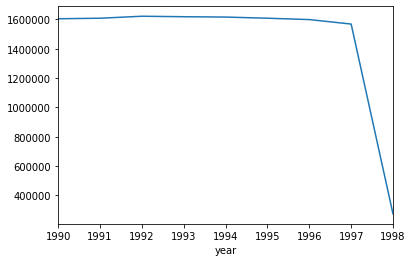

In [66]:
disease="Tuberculosis"
measure="Deaths"
metric="Number"
data=pivoted.loc[countries, years, disease, measure][metric] 
data.groupby("year").sum().plot()

Data for 1998 seems to be missing. Plotting percentage of Tuberculosis per country per year.

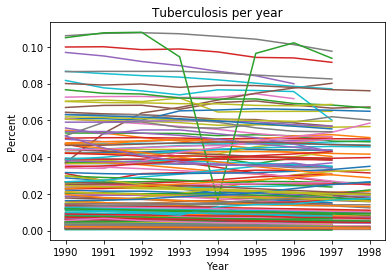

In [67]:
disease="Tuberculosis"
measure="Deaths"
metric="Percent"
#countries=[]
for country in countries:
    yearsFound=[]
    yearlyData=[]
    for year in years:
        try:
            data=pivoted.loc[country, year, disease, measure][metric] #take value using multi index
            yearsFound.append(year)
            yearlyData.append(data)
        except KeyError as e:
            #print("KeyEData missing:", country, year, disease, measure, metric)
            pass
    plt.plot(yearsFound, yearlyData, label=country)
    plt.title(disease+" per year")

#plt.legend()
plt.xlabel("Year")
plt.ylabel(metric)
plt.show()

As we can see, many countries are missing data from 1998. Now, we will save the data per year for each country with countries as columns, in order to be able to look at correlations.

In [68]:
disease="Tuberculosis"
measure="Deaths"
metric="Number"
dataArray=np.zeros((len(years), len(countries)))
#countries=[]
for i in range(len(countries)):
    country=countries[i]
    for j in range(len(years)):
        year=years[j]
        try:
            data=pivoted.loc[country, year, disease, measure][metric] #take value using multi index
        except KeyError as e:
            #print("KeyEData missing:", country, year, disease, measure, metric)
            data=np.nan
        dataArray[j][i]=data
        
tuberculosisDeaths=pd.DataFrame(dataArray, columns=countries, index=years)
tuberculosisDeaths

Afghanistan    Albania     Algeria  American Samoa   Andorra  \
1990  4332.690583  43.079440  779.958290        0.773222  0.436941   
1991  4288.640464  42.526733  740.948438        0.795365  0.449887   
1992  4475.257542  39.054536  713.016397        0.804960  0.461491   
1993  4909.050325  35.627937  689.954847        0.801405  0.474082   
1994  5352.634058  31.721989  668.843243        0.795520  0.471855   
1995  5536.274369  28.743219  643.522592        0.782169  0.464592   
1996  5560.655853  28.506160  622.991901        0.762092  0.452945   
1997  5605.857165  26.950767  610.510155        0.749252  0.437609   
1998  5584.296859  25.611580  595.371273             NaN  0.420874   

            Angola  Antigua and Barbuda    Argentina     Armenia  Australia  \
1990  12041.070681             0.774593  1567.785312  116.612749  96.392374   
1991  12338.614569             0.741975  1518.257306  122.143199  95.562111   
1992  12692.316550             0.731209  1485.491659  132.234605  97.380325   
1993  13249.593552             0.716429  1417.510354  139.278402  95.118124   
1994  13722.477161             0.707799  1342.103814  141.792121  95.372805   
1995  13847.372208             0.711674  1307.348040  141.323738  92.783504   
1996  13510.307314             0.679918  1266.332936  139.023931  91.914003   
1997  13517.398324             0.653671  1189.156609  140.904627  85.065331   
1998  14533.712658                  NaN          NaN  139.362774  84.787909   

      ...  United States     Uruguay   Uzbekistan    Vanuatu    Venezuela  \
1990  ...    2279.627375  165.121696  1686.162815  27.591092  1035.853116   
1991  ...    2193.880713  195.576708  1786.342686  27.526581   997.303427   
1992  ...    2071.063855  163.909796  1892.527215  27.490559   934.994306   
1993  ...    2017.892729  149.093978  2076.432736  27.432716   920.570380   
1994  ...    1906.157570  131.423812  2275.108481  27.100185   943.013780   
1995  ...    1807.515953  123.635242  2458.922300  26.713180   897.260839   
1996  ...    1695.273320  113.288696  2687.330180  26.284502   829.547539   
1997  ...    1597.842407  103.040501  2946.208860  25.925317   782.614281   
1998  ...            NaN         NaN          NaN        NaN          NaN   

           Vietnam  Virgin Islands, U.S.        Yemen       Zambia  \
1990  27361.366777              1.383504  1773.425385  3983.880861   
1991  27127.397768              1.299984  1727.041229  4322.837618   
1992  26830.722856              1.247286  1685.812043  4719.281969   
1993  26497.595672              1.206131  1651.634438  5154.310787   
1994  26005.380195              1.189061  1598.617522  5608.223316   
1995  25374.450576              1.173262  1546.810273  6044.763732   
1996  24829.175422              1.120548  1491.499967  6389.426355   
1997  24449.117796              1.064923  1448.040242  6727.279327   
1998           NaN              1.024850  1401.722336          NaN   

         Zimbabwe  
1990  4210.173921  
1991  4021.407837  
1992  4073.714934  
1993  4195.790839  
1994  4423.034107  
1995  4827.640154  
1996  5108.920405  
1997  5791.805273  
1998          NaN  

[9 rows x 195 columns]

The data for some years are missing for a few countries. Right now, we will just drop these years. Later on, we might investigate why the data is missing.

In [69]:
tuberculosisDeathsClean=tuberculosisDeaths.dropna(axis=0)
tuberculosisDeathsClean

Afghanistan    Albania     Algeria  American Samoa   Andorra  \
1990  4332.690583  43.079440  779.958290        0.773222  0.436941   
1991  4288.640464  42.526733  740.948438        0.795365  0.449887   
1992  4475.257542  39.054536  713.016397        0.804960  0.461491   
1993  4909.050325  35.627937  689.954847        0.801405  0.474082   
1994  5352.634058  31.721989  668.843243        0.795520  0.471855   
1995  5536.274369  28.743219  643.522592        0.782169  0.464592   
1996  5560.655853  28.506160  622.991901        0.762092  0.452945   

            Angola  Antigua and Barbuda    Argentina     Armenia  Australia  \
1990  12041.070681             0.774593  1567.785312  116.612749  96.392374   
1991  12338.614569             0.741975  1518.257306  122.143199  95.562111   
1992  12692.316550             0.731209  1485.491659  132.234605  97.380325   
1993  13249.593552             0.716429  1417.510354  139.278402  95.118124   
1994  13722.477161             0.707799  1342.103814  141.792121  95.372805   
1995  13847.372208             0.711674  1307.348040  141.323738  92.783504   
1996  13510.307314             0.679918  1266.332936  139.023931  91.914003   

      ...  United States     Uruguay   Uzbekistan    Vanuatu    Venezuela  \
1990  ...    2279.627375  165.121696  1686.162815  27.591092  1035.853116   
1991  ...    2193.880713  195.576708  1786.342686  27.526581   997.303427   
1992  ...    2071.063855  163.909796  1892.527215  27.490559   934.994306   
1993  ...    2017.892729  149.093978  2076.432736  27.432716   920.570380   
1994  ...    1906.157570  131.423812  2275.108481  27.100185   943.013780   
1995  ...    1807.515953  123.635242  2458.922300  26.713180   897.260839   
1996  ...    1695.273320  113.288696  2687.330180  26.284502   829.547539   

           Vietnam  Virgin Islands, U.S.        Yemen       Zambia  \
1990  27361.366777              1.383504  1773.425385  3983.880861   
1991  27127.397768              1.299984  1727.041229  4322.837618   
1992  26830.722856              1.247286  1685.812043  4719.281969   
1993  26497.595672              1.206131  1651.634438  5154.310787   
1994  26005.380195              1.189061  1598.617522  5608.223316   
1995  25374.450576              1.173262  1546.810273  6044.763732   
1996  24829.175422              1.120548  1491.499967  6389.426355   

         Zimbabwe  
1990  4210.173921  
1991  4021.407837  
1992  4073.714934  
1993  4195.790839  
1994  4423.034107  
1995  4827.640154  
1996  5108.920405  

[7 rows x 195 columns]

Seems like the data for 1997, 1998 is incomplete.

Now lets finally look at correlation.

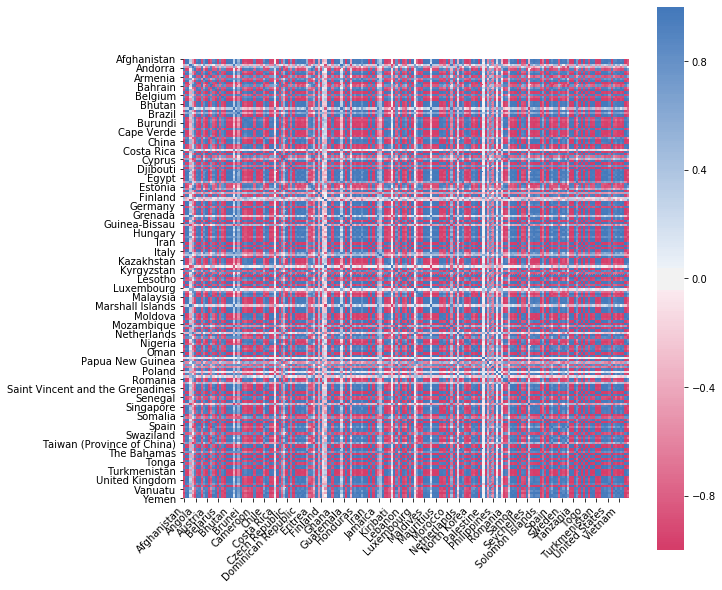

In [70]:
#Correlation matrix
corr=tuberculosisDeathsClean.corr(method ='pearson') 
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(0, 250, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

The correlation matrix appears interesting, there are lots of strong correlations! However, correlation does not equal causation. 

Grouping countries according to the correlation between deaths per year may reveal more. We will do this by utilizing hierachial clustering.

                              1990          1991          1992          1993  \
Afghanistan            4332.690583   4288.640464   4475.257542   4909.050325   
Albania                  43.079440     42.526733     39.054536     35.627937   
Algeria                 779.958290    740.948438    713.016397    689.954847   
American Samoa            0.773222      0.795365      0.804960      0.801405   
Andorra                   0.436941      0.449887      0.461491      0.474082   
...                            ...           ...           ...           ...   
Vietnam               27361.366777  27127.397768  26830.722856  26497.595672   
Virgin Islands, U.S.      1.383504      1.299984      1.247286      1.206131   
Yemen                  1773.425385   1727.041229   1685.812043   1651.634438   
Zambia                 3983.880861   4322.837618   4719.281969   5154.310787   
Zimbabwe               4210.173921   4021.407837   4073.714934   4195.790839   

                              1994     

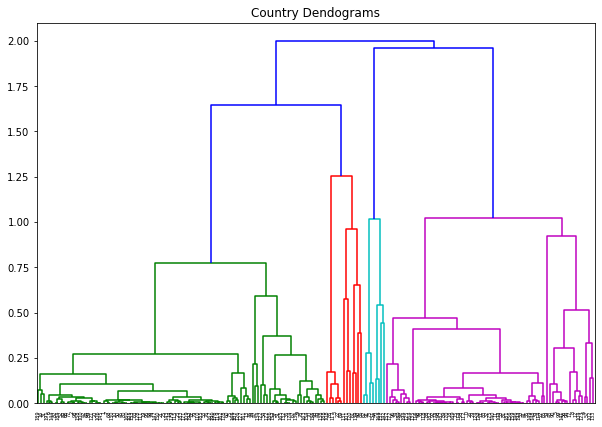

In [71]:
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

tuberculosisDeaths2=tuberculosisDeathsClean.transpose()
print(tuberculosisDeaths2)
plt.figure(figsize=(10, 7))
plt.title("Country Dendograms")
link=shc.linkage(tuberculosisDeaths2, metric="correlation", method="complete")
dend = shc.dendrogram(link)

Now, complete linkage between cluisters has been used. Single or other linkage methods could also be experimented with, later on.

We will define a function for plotting.

In [72]:
def plot_map_categories(dataset, title_string = ""):
    from bokeh.palettes import viridis
    dataset=dataset.dropna(axis=0) 
    dataset = gdf.merge(dataset, left_on = 'country', right_on = 'location', how = 'left')
    dataset=dataset.dropna(axis=0) 
    #Read data to json
    dataset_json = json.loads(dataset.to_json())

    #Convert to str like object
    dataset_json_data = json.dumps(dataset_json)

    #Input GeoJSON source that contains features for plotting.
    geosource = GeoJSONDataSource(geojson = dataset_json_data)

    #Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
    catValues=list(np.unique(dataset["val"]).astype("str"))
    palette=viridis(len(catValues))
    print("Labels")
    print(catValues)
    print("Coulours")
    print(palette)
    color_mapper = CategoricalColorMapper(palette = palette , factors=catValues)

    #Create figure object.
    p = figure(title = title_string, plot_height = 600 , plot_width = 950, toolbar_location = None)
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None

    #Add patch renderer to figure. 
    p.patches('xs','ys', source = geosource,fill_color = {'field' :'val', 'transform' : color_mapper})

    #Display figure inline in Jupyter Notebook.
    output_notebook()

    #Display figure.
    show(p)

Cutting the dendrogram at a specific height. Leter, we want to implement a slider for this, to allow to see which countries are most correlated on a world map.

In [73]:
cutTree = shc.cut_tree(link, height=0.25)
tuberculosisDeaths2["Group"]=cutTree
toPlot=tuberculosisDeaths2.copy()
toPlot["location"]=tuberculosisDeaths2.index
toPlot=toPlot.reset_index()[["location", "Group"]].rename(columns={"Group": "val"})
plot_map_categories(toPlot, title_string="Countries grouped by correlation for tuberculosis deaths")

Labels
['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0', '12.0', '13.0', '14.0', '15.0', '16.0', '17.0', '18.0', '19.0', '20.0', '21.0', '22.0', '23.0', '24.0']
Coulours
['#440154', '#470F62', '#481E70', '#472B7A', '#443982', '#3F4587', '#3B518A', '#355C8C', '#30678D', '#2C718E', '#287B8E', '#24858D', '#208F8C', '#1E998A', '#1FA386', '#27AD80', '#35B778', '#45BF6F', '#5BC862', '#72CF55', '#8DD644', '#AADB32', '#C5DF21', '#E1E318', '#FDE724']


Loading BokehJS ...

TODO: The mapping does not work for categorical values. Reason unknown, this wil be fixed. Then, a slider will be implemented.

Mapping works for same data using non-gategorical endcoding. This is nonsense, not very enlightening... 

In [74]:
plot_map(toPlot, title_string="Countries grouped by correlation for tuberculosis deaths")

Loading BokehJS ...

Define another function for this process:

In [75]:
def correlationPlots(pivoted, disease, measure, metric, years, countries, cutOff, hierarchMethod):    
    dataArray=np.zeros((len(years), len(countries)))
    #countries=[]
    for i in range(len(countries)):
        country=countries[i]
        for j in range(len(years)):
            year=years[j]
            try:
                data=pivoted.loc[country, year, disease, measure][metric] #take value using multi index
            except KeyError as e:
                #print("KeyEData missing:", country, year, disease, measure, metric)
                data=np.nan
            dataArray[j][i]=data

    data=pd.DataFrame(dataArray, columns=countries, index=years)
    print("Dropped years with missing values")
    data=data.dropna(axis=0)
    data=data.transpose()
    plt.figure(figsize=(10, 7))
    plt.title("Country Dendograms")
    link=shc.linkage(data, metric="correlation", method=hierarchMethod)
    dend = shc.dendrogram(link)
    cutTree = shc.cut_tree(link, height=cutOff)
    data["Group"]=cutTree
    data["location"]=data.index
    dataPlot=data.reset_index()[["location", "Group"]].rename(columns={"Group": "val"})
    plot_map_categories(dataPlot, title_string="Countries grouped by correlation for tuberculosis deaths")

Lets do the same for malaria and tropical diseases.

Dropped years with missing values
Labels
['0.0', '1.0', '2.0', '4.0', '5.0', '6.0', '7.0', '8.0', '10.0', '11.0', '12.0', '13.0', '15.0', '16.0', '17.0', '18.0', '19.0', '20.0', '21.0', '22.0', '23.0', '25.0', '26.0', '28.0', '29.0', '30.0', '31.0', '32.0', '33.0', '34.0', '35.0', '36.0', '38.0', '39.0', '40.0', '41.0', '42.0', '43.0', '44.0', '46.0', '47.0', '48.0', '49.0', '50.0', '51.0', '52.0', '53.0', '54.0', '56.0', '57.0', '59.0', '62.0', '65.0', '66.0', '67.0', '69.0', '70.0', '71.0', '73.0']
Coulours
['#440154', '#45065A', '#460C5F', '#471466', '#48196B', '#481E70', '#472575', '#472A79', '#46307D', '#453580', '#433A83', '#424085', '#404487', '#3D4A89', '#3C4E8A', '#3A538B', '#37588C', '#355C8C', '#33618D', '#31658D', '#2F698D', '#2D6E8E', '#2C728E', '#2A778E', '#287A8E', '#277E8E', '#25838D', '#23878D', '#228B8D', '#208F8C', '#1F938B', '#1E988A', '#1E9B89', '#1EA087', '#20A485', '#22A784', '#26AC81', '#2AB07E', '#30B47A', '#36B877', '#3DBB74', '#45BF6F', '#4DC26B', '#57C665', 

Loading BokehJS ...

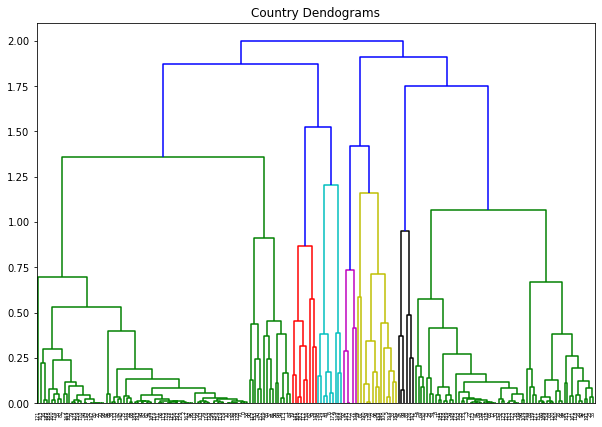

In [76]:
disease='Neglected tropical diseases and malaria'
measure="Deaths"
metric="Number"
correlationPlots(pivoted, disease, measure, metric, years, countries, 0.1, "complete")   

And for cardiovascular diseases, which are not infectious. However, due to the socio-economical factors and correlations above, we still expect to find some kind of correlations. The grouping can therefore be done.

When the world maps are working, they could reveal interesting info. One hypothesis is that the grouping for infectious diseases is more geographical, while the grouping for cardiovascular more dependent on socio-economic factors.

Dropped years with missing values
Labels
['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0', '12.0', '13.0', '14.0', '15.0', '16.0', '17.0', '18.0', '19.0', '20.0', '21.0', '22.0', '23.0', '24.0', '25.0', '26.0', '27.0', '28.0', '29.0', '30.0', '31.0', '32.0', '33.0', '34.0', '35.0', '36.0', '37.0', '38.0', '39.0', '40.0', '41.0', '42.0', '43.0', '44.0', '45.0', '46.0', '47.0', '49.0', '50.0', '51.0', '54.0']
Coulours
['#440154', '#45085B', '#470F62', '#471669', '#481D6F', '#482374', '#472A79', '#46307D', '#453681', '#433C84', '#414286', '#3E4888', '#3C4D8A', '#3A538B', '#37588C', '#355D8C', '#32628D', '#30678D', '#2E6C8E', '#2C718E', '#2A768E', '#287A8E', '#267F8E', '#24848D', '#23898D', '#218D8C', '#1F928C', '#1E978A', '#1E9B89', '#1EA087', '#20A585', '#23A982', '#28AE7F', '#2EB27C', '#35B778', '#3DBB74', '#45BF6F', '#4FC369', '#59C764', '#64CB5D', '#70CE56', '#7CD24F', '#88D547', '#95D73F', '#A2DA37', '#AFDC2E', '#BDDE26', '#CAE01E', '#D7E219', '#E

Loading BokehJS ...

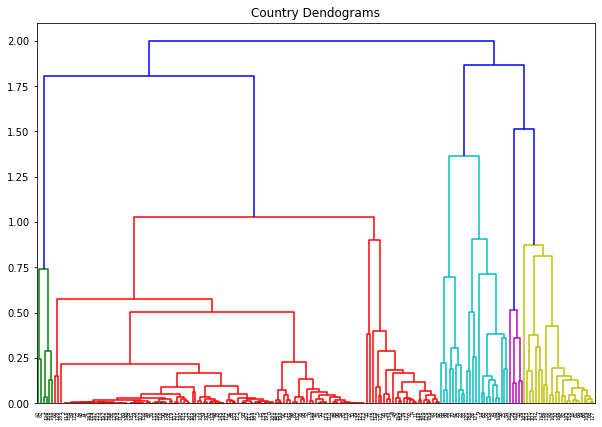

In [77]:
disease='Cardiovascular diseases'
measure="Deaths"
metric="Number"
correlationPlots(pivoted, disease, measure, metric, years, countries, 0.1, "complete")  

# 3. How is the prevalence of different diseases linked to different risk factors?

## 3.1 Cardiovascular diseases

To better understand the risks factors for cardiovascular diseases, we analyse this dataset: https://www.kaggle.com/sulianova/cardiovascular-disease-dataset, which contains data about the health condition of a list of people, including whether or not they have cardiovascular diseases.

### 3.1.1 Data cleaning/exploration

In [32]:
df=pd.read_csv("cardio_train.csv", delimiter=';')
print(df.shape)
df.head(5)

(70000, 13)


id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0

In [33]:
# No missing data (yey!)
df.isnull().values.any()

False

The feature "age" is given as a integer amount of days, let's convert this to a float in years.

In [34]:
# approximation: 1 year = 365 days
df['age'] = df['age'] / 365

**Let's check if each column has realistic values:**

In [35]:
# The range of ages seems reasonable
print(np.sort(df['age'].unique()))

[29.58356164 29.75068493 29.80273973 ... 64.90958904 64.93424658
 64.96712329]


In [36]:
# there seem to be some very short and tall people in this dataset !! (shortest person ever recorded was 54.6 cm)
print(np.sort(df['height'].unique()))

[ 55  57  59  60  64  65  66  67  68  70  71  72  74  75  76  80  81  91
  96  97  98  99 100 104 105 108 109 110 111 112 113 117 119 120 122 125
 128 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182
 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 200 207
 250]


[[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F0E3DB8408>]] 165    5853
160    5022
170    4679
168    4399
164    3396
       ... 
81        1
80        1
207       1
76        1
64        1
Name: height, Length: 109, dtype: int64


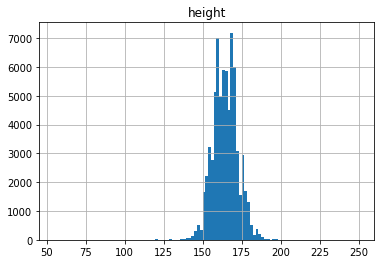

In [37]:
# There seem to be many different very short people in this dataset, let's visualize the distribution.
hist = df.hist(bins=len(df['height'].unique()), column="height")
print(hist, df['height'].value_counts())

In [38]:
# The distribution does seem to be sharply peaked around the realistic value. Let's remove the unrealistic outliers
realistic = df[df['height']>120]
realistic = realistic[realistic['height']<210]

In [39]:
# Let's split the dataset into male and female and determine the average height
print('genders: '+str(realistic['gender'].unique()))

females = realistic[realistic['gender'] == 1]
males = realistic[realistic['gender'] == 2]

print('Average height of a female: '+ str(np.round(females['height'].mean(),2))+' cm')
print('Average height of a male: '+ str(np.round(males['height'].mean(),2))+' cm')

genders: [2 1]
Average height of a female: 161.43 cm
Average height of a male: 170.04 cm


These values seem quiet low, however, we don't know when/where this data was recorded. <br>
We will get back to this and try to figure out where this data was recorded.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F0E46CFC88>]],
      dtype=object)

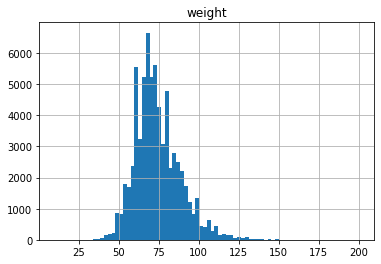

In [40]:
# There are also some unrealistic low weight values (expressed in kg)
hist = realistic.hist(bins=80, column="weight")
hist

In [41]:
print('low weights: '+str(np.sort(realistic['weight'].unique())[:10]))

low weights: [10. 11. 21. 22. 23. 28. 29. 30. 31. 32.]


In [42]:
#Remove extremely low weights
realistic = realistic[realistic['weight']>35]

In [43]:
# ap_hi: Systolic (arterial) blood pressure (pressure just outside the heart while it is ejecting)
# ap_hi: Diastolic (arterial) blood pressure (pressure just outside the heart while it is filling)
print(np.sort(realistic['ap_hi'].unique()))
print(np.sort(realistic['ap_lo'].unique()))

[ -150  -140  -120  -115  -100     1     7    10    11    12    13    14
    15    16    17    20    24    60    70    80    85    90    93    95
    96    97    99   100   101   102   103   104   105   106   107   108
   109   110   111   112   113   114   115   116   117   118   119   120
   121   122   123   124   125   126   127   128   129   130   131   132
   133   134   135   136   137   138   139   140   141   142   143   144
   145   146   147   148   149   150   151   152   153   154   155   156
   157   158   159   160   161   162   163   164   165   166   167   168
   169   170   171   172   173   174   175   176   177   178   179   180
   181   184   185   187   188   190   191   193   195   196   197   199
   200   202   207   210   215   220   230   240   309   401   701   806
   902   906   907   909   960  1110  1130  1202  1205  1300  1400  1409
  1420  1500  1620  2000 11020 11500 13010 14020 16020]
[  -70     0     1     6     7     8     9    10    15    20    30  

We can assume these negative pressures to be typos since their magnitude is realistic

In [44]:
#Fix the negative values
realistic = realistic.abs()

In [45]:
# In reality systolic blood pressure is rarely much lower lower than 90 or higher than 200
realistic = realistic[realistic['ap_hi']>59]
realistic = realistic[realistic['ap_hi']<241]
realistic = realistic[realistic['ap_lo']>39]
realistic = realistic[realistic['ap_lo']<200]
print(np.sort(realistic['ap_hi'].unique()))
print(np.sort(realistic['ap_lo'].unique()))

[ 60.  70.  80.  85.  90.  93.  95.  96.  97.  99. 100. 101. 102. 103.
 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117.
 118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130. 131.
 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144. 145.
 146. 147. 148. 149. 150. 151. 152. 153. 154. 155. 156. 157. 158. 159.
 160. 161. 162. 163. 164. 165. 166. 167. 168. 169. 170. 171. 172. 173.
 174. 175. 176. 177. 178. 179. 180. 184. 185. 187. 188. 190. 191. 193.
 195. 196. 197. 200. 202. 210. 215. 220. 230. 240.]
[ 40.  45.  49.  50.  52.  53.  54.  55.  56.  57.  58.  59.  60.  61.
  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.  75.
  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.
  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103.
 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 118. 119.
 120. 121. 122. 125. 126. 130. 135. 140. 150. 160. 170. 180. 182. 190.]


What is also an interesting and important parameter when trying to quantify the performance of the heart is "Pulse Pressure" (ap_pulse) which can simply be calculated as follows: ap_pulse = ap_hi - ap_lo.

In [46]:
# Let's add thise parameter into our dataframe
realistic['ap_pulse'] = realistic['ap_hi'] - realistic['ap_lo']
df1 = realistic.pop('cardio')
realistic['cardio'] = df1
realistic.head()

id        age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  \
0  0.0  50.391781     2.0   168.0    62.0  110.0   80.0          1.0   1.0   
1  1.0  55.419178     1.0   156.0    85.0  140.0   90.0          3.0   1.0   
2  2.0  51.663014     1.0   165.0    64.0  130.0   70.0          3.0   1.0   
3  3.0  48.282192     2.0   169.0    82.0  150.0  100.0          1.0   1.0   
4  4.0  47.873973     1.0   156.0    56.0  100.0   60.0          1.0   1.0   

   smoke  alco  active  ap_pulse  cardio  
0    0.0   0.0     1.0      30.0     0.0  
1    0.0   0.0     1.0      50.0     1.0  
2    0.0   0.0     0.0      60.0     1.0  
3    0.0   0.0     1.0      50.0     1.0  
4    0.0   0.0     0.0      40.0     0.0

In [47]:
# We find that in some cases the the diastolic pressure is higher than the systolic pressure, this is physiologically impossible.
print(np.sort(realistic['ap_pulse'].unique()))

[-90. -85. -75. -70. -65. -60. -50. -45. -40. -35. -30. -25. -20. -10.
  -5.   0.   5.   9.  10.  11.  12.  14.  15.  17.  18.  19.  20.  21.
  22.  23.  24.  25.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.
  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47.  48.  49.  50.
  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.  61.  62.  63.  64.
  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.
  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.
  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103. 105. 106. 107.
 108. 109. 110. 113. 114. 115. 120. 121. 130. 135. 140.]


In [48]:
# Remove negative values and unrealisticly high values.
realistic = realistic[realistic['ap_pulse']>0]
realistic = realistic[realistic['ap_pulse']<100]
print(np.sort(realistic['ap_pulse'].unique()))

[ 5.  9. 10. 11. 12. 14. 15. 17. 18. 19. 20. 21. 22. 23. 24. 25. 27. 28.
 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46.
 47. 48. 49. 50. 51. 52. 53. 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64.
 65. 66. 67. 68. 69. 70. 71. 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82.
 83. 84. 85. 86. 87. 88. 89. 90. 91. 92. 93. 94. 95. 96. 97. 98. 99.]


In [49]:
# The other features seem to be clean
print(np.sort(realistic['cholesterol'].unique()))
print(np.sort(realistic['gluc'].unique()))
print(np.sort(realistic['smoke'].unique()))
print(np.sort(realistic['alco'].unique()))
print(np.sort(realistic['active'].unique()))
print('Data lost in the cleaning process: '+str(100*(70000-realistic.shape[0])/70000)+' %')

[1. 2. 3.]
[1. 2. 3.]
[0. 1.]
[0. 1.]
[0. 1.]
Data lost in the cleaning process: 2.33 %


**Now let's see how the different features are correlated.**

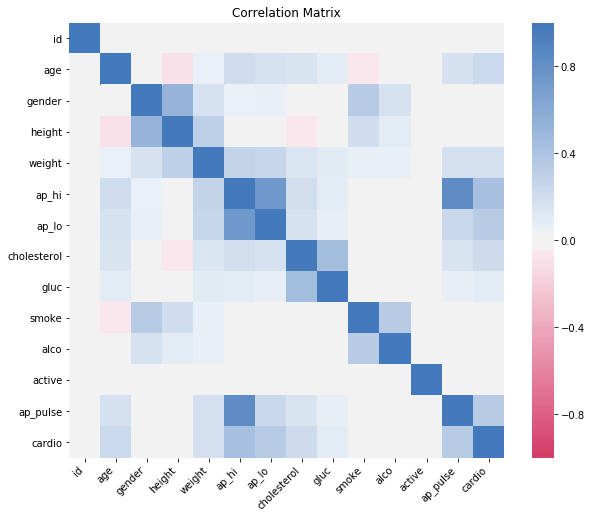

In [50]:
corr = realistic.corr()

fig, ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(0, 250, n=200),
    square=True
)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_title('Correlation Matrix')
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

**Implementing a measure of obesity: BMI**

Height & weight are also clearly strongly correlated, which makes a lot of sense. We would be more interested in the "obesity" of the patient, which is better quantified by the Body Mass Index: BMI = weight / height². Let us remove "height" and "weight" from out dataframe and instead combine them into BMI.

In [51]:
df = realistic

df['weight'] = df['weight'] / (df['height']/100)**2
df = df.rename(columns = {"weight": "BMI"})
df = df.drop(columns=['height'])
df.head()

id        age  gender        BMI  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0  0.0  50.391781     2.0  21.967120  110.0   80.0          1.0   1.0    0.0   
1  1.0  55.419178     1.0  34.927679  140.0   90.0          3.0   1.0    0.0   
2  2.0  51.663014     1.0  23.507805  130.0   70.0          3.0   1.0    0.0   
3  3.0  48.282192     2.0  28.710479  150.0  100.0          1.0   1.0    0.0   
4  4.0  47.873973     1.0  23.011177  100.0   60.0          1.0   1.0    0.0   

   alco  active  ap_pulse  cardio  
0   0.0     1.0      30.0     0.0  
1   0.0     1.0      50.0     1.0  
2   0.0     0.0      60.0     1.0  
3   0.0     1.0      50.0     1.0  
4   0.0     0.0      40.0     0.0

The very last column of the data "cardio" is a binary value which determines wether the concidered person was diagnosed with cardio vascular disease. <br> Note that in reality this is not at all "binary", as it doesn't quanity the severity/type of cardio vascular disease.<br>

Let's try to get a **deeper understanding of the different features in this dataset before attemption to draw conclusions.**

### 3.1.2 Age

Why is cardiovascular disease the most common cause of death? <br>
From a medical point of view, cardiovascular disease is fairly well understood, so why is it that as of today it can't simply be prevented?

It turns out that cardiovascular disease comes with a certain level of "inevetability", this is in part due to a phenonmenon known as "arterial stiffening" which is directly related to ageing.

Large arteries are roughly devided into 3 main sections:
<img src="section-artery.jpg" width="400" height="180">

It is the middle section that causes the main problem, it contains elastic fibres (a protein known as elastin) which gives the artery its elastic properties and helps the blood to be pumped around in your body. As it turns out, since this layer is sandwhiched between two other layers, our body has trouble repairing/replacing the elastin as it degrades over time. Additionally it has been shown that elastin proteins have an approximate half-life of 74 years (Shapiro et al., 1991). This value is relatively close to the current life expectancy in developed countries (~80y). <br> (Another direct reason for ageing is telomere shorting which causes DNA damage and cell death).

Observe that, the feature "age" is strongly correlation to the prevalence of cardio vascular disease which is very much expected concidering what was discussed above.

### 3.1.3 Cholesterol

Cholesterol plays a crucial role in the cell membrane of every cell in your body, it also helps your body synthesize steroid hormones, bile acid and vitamin D. So how is it possible that its prevalence is so strongly correlated to the most common cause of death?

Cholesterol is a lipid, it is a type of "fat". It can build up excessively in the blood circulation and can be hard for the body to remove. The cholesterol (plaque) attaches to the blood vessel walls caussing them to narrow. This negatively effects the heamodynamics and can ultimately result in total occlusion of a blood vessle. The blockage results in poor perfusion and thus insufficient oxygen being delivered to the tissue.<br>

<img src="plaque.png" width="300" height="130">

This process is accelerated by a unhealthy diet and is thus correlated to obesity.

### 3.1.4 Blood Pressure

elevated blood pressure is in general a result of many influencing factors.

* Short term: When you drink a large amount of fluid or eat something (salty), your blood pressure will rise. In young, healthy individuals the body is easily counteracts this by its many negative feedback loops.

* Long term: Blood pressure increases with age as a result of arterial stiffening, build up of cholesterol, ... <br>

Note that cardiovascular disease, especially coronary heart disease is a **positive feedbackloop**! This is exactly what makes it so deadly. <br>
explanation: If the heart lowers in function, it is unable to pump blood around the body properly and provide the different tissues of sufficient oxygen. This means all tissues in the body will lower in function, including the heart muscles themselves. This causes the heart function to decrease even further. This escalates in a condition known as heart failure.

### 3.1.5 Other interesting correlations

Interestingly, the strongest correlations in this dataset are not related to cardiovascular disease:

- height ~ gender
- height ~ weight
- cholesterol ~ glocuse levels (unhealthy diet)
- smoking ~ alcohol (unhealthy lifestyles)
- smoking ~ gender

**side quest:** Especially the last correlation is interesting. Which gender smokes most? How big is this difference?

In [52]:
GS = df[['gender','smoke']]

females = GS[GS['gender']==1]
males = GS[GS['gender']==2]

print('male smokers: '+str(np.round(100*sum(males['smoke'])/males.size, 3))+'%')
print('female smokers: '+str(np.round(100*sum(females['smoke'])/females.size, 3))+'%')

male smokers: 10.95%
female smokers: 0.89%


According to this dataset, men smoke 10x more than woman!<br>
This approximately agrees with findings in literature.

### 3.1.6 Feature importance

Correlations alone aren't always an accurate way of describing which features are truly important. Forest algorithm to determine which features are important:

In [53]:
X = df.iloc[:,1:-1]
y = df.iloc[:,-1]

Feature ranking:
1. feature 0 (0.356879)age
2. feature 2 (0.313090)BMI
3. feature 3 (0.114377)ap_hi
4. feature 10 (0.071101)ap_pulse
5. feature 4 (0.061604)ap_lo
6. feature 5 (0.041434)cholesterol
7. feature 6 (0.013479)gluc
8. feature 1 (0.009778)gender
9. feature 9 (0.007135)active
10. feature 7 (0.005720)smoke
11. feature 8 (0.005403)alco


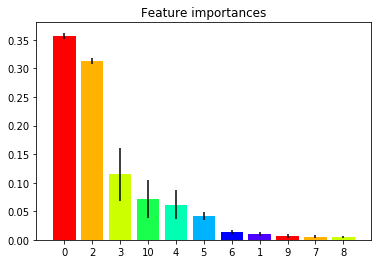

In [54]:
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]])+X.columns[indices[f]])

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color=[(1, 0, 0, 1),(1, 0.7, 0, 1),(0.8, 1, 0, 1),(0.1, 1, 0.3, 1),(0, 1, 0.7, 1),(0, 0.7, 1, 1),(0, 0, 1, 1),(0.3, 0, 1, 1)], yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

PLOT ABOVE: to embed!

We find similar results as to the correlations, however, here the blood pressure seems to play much more important role. 
BMI also turns out to be a very important factor!

### 3.1.7 Conclusion

Many of the above factors can not directly be influenced/solved: 
* We can't prevent ourselves from ageing 
* High blood pressure is a result of other factors: ageing (arterial stiffening), cholesterol levels, salt/fluid intake, ...

So in order to **minimize our risk of cardiovascular disease** we should try to keep our BMI and cholesterol levels as low as possible. <br>
This can both be done be following a **healthy diet and working out (burning fat).**

## 3.2 Further risk factor analysis

We can now do the following things:
* Use the data from question 1 to analyse specific risk factors and the phenomena observed in that question.
* Perform analyses like this one for cardiovascular diseases for other diseases.
* Try to link the risk factors identified here with health data about different countries.

## 3.3 Risk factors in GBD dataset

In [96]:
df_risk_exposure = pd.read_csv("data/risk-exposure.csv")
df_risk_exposure = replace_names(df_risk_exposure, pairDf["Country"], pairDf["Replacement"])
df_risk_exposure

Replaced Bolivia with Bolivia (Plurinational State of)
Replaced Brunei with Brunei Darussalam
Replaced Cape Verde with Cabo Verde
Replaced Cote d'Ivoire with Côte d'Ivoire
Replaced Czech Republic with Czechia
Replaced Democratic Republic of the Congo with Congo, Democratic Republic of the
Replaced Federated States of Micronesia with Micronesia (Federated States of)
Replaced Iran with Iran (Islamic Republic of)
Replaced Laos with Lao People's Democratic Republic
Replaced Macedonia with North Macedonia
Replaced Moldova with Moldova, Republic of
Replaced North Korea with Korea (Democratic People's Republic of)
Replaced Palestine with Palestine, State of
Replaced South Korea with Korea, Republic of
Replaced Syria with Syrian Arab Republic
Replaced Taiwan (Province of China) with Taiwan, Province of China
Replaced Tanzania with Tanzania, United Republic of
Replaced The Bahamas with Bahamas
Replaced The Gambia with Gambia
Replaced United Kingdom with United Kingdom of Great Britain and North

measure location   sex       age  \
0      Summary exposure value    Chile  Both  All Ages   
1      Summary exposure value    Chile  Both  All Ages   
2      Summary exposure value  Uruguay  Both  All Ages   
3      Summary exposure value  Uruguay  Both  All Ages   
4      Summary exposure value  Uruguay  Both  All Ages   
...                       ...      ...   ...       ...   
54595  Summary exposure value  Iceland  Both  All Ages   
54596  Summary exposure value  Iceland  Both  All Ages   
54597  Summary exposure value  Iceland  Both  All Ages   
54598  Summary exposure value  Iceland  Both  All Ages   
54599  Summary exposure value  Iceland  Both  All Ages   

                                rei metric  year        val      upper  \
0          Impaired kidney function   Rate  1998   2.206156   6.254720   
1              High LDL cholesterol   Rate  1998  11.781258  13.439133   
2                       Alcohol use   Rate  1998  17.024161  23.759901   
3                          Drug use   Rate  1998   0.522109   0.767074   
4       High fasting plasma glucose   Rate  1998   4.868456   7.082223   
...                             ...    ...   ...        ...        ...   
54595                      Drug use   Rate  2010   0.357157   0.453165   
54596   High fasting plasma glucose   Rate  2010   4.233970   6.021667   
54597  High systolic blood pressure   Rate  2010   8.919840   9.762758   
54598          High body-mass index   Rate  2010  16.592588  21.117256   
54599      Low bone mineral density   Rate  2010   6.048110   7.164240   

           lower  
0       0.991032  
1      10.229339  
2      11.266339  
3       0.386055  
4       3.521469  
...          ...  
54595   0.292774  
54596   3.041318  
54597   8.028875  
54598  12.963985  
54599   5.026554  

[54600 rows x 10 columns]

Which risk factors are in the GBD dataset?

In [41]:
print(df_risk_exposure['rei'].unique())

['Impaired kidney function' 'High LDL cholesterol' 'Alcohol use'
 'Drug use' 'High fasting plasma glucose' 'High systolic blood pressure'
 'High body-mass index' 'Low bone mineral density' 'Low physical activity'
 'Intimate partner violence']


In [92]:
df_risk_exposure['year'].sort_values().unique()

array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017], dtype=int64)

In [264]:
health_risk_factors = pd.read_csv("data/health_risk_factors.csv")
health_risk_factors

Series Name     Series Code  \
0                Prevalence of overweight (% of adults)  SH.STA.OWAD.ZS   
1                Prevalence of overweight (% of adults)  SH.STA.OWAD.ZS   
2                Prevalence of overweight (% of adults)  SH.STA.OWAD.ZS   
3                Prevalence of overweight (% of adults)  SH.STA.OWAD.ZS   
4                Prevalence of overweight (% of adults)  SH.STA.OWAD.ZS   
...                                                 ...             ...   
1813                                                NaN             NaN   
1814                                                NaN             NaN   
1815                                                NaN             NaN   
1816  Data from database: Health Nutrition and Popul...             NaN   
1817                           Last Updated: 09/25/2019             NaN   

        Country Name Country Code 1990 [YR1990] 1991 [YR1991] 1992 [YR1992]  \
0        Afghanistan          AFG          10.4          10.7            11   
1            Albania          ALB          40.5            41          41.5   
2            Algeria          DZA          41.4          42.2            43   
3     American Samoa          ASM            ..            ..            ..   
4            Andorra          AND          56.4          56.8          57.2   
...              ...          ...           ...           ...           ...   
1813             NaN          NaN           NaN           NaN           NaN   
1814             NaN          NaN           NaN           NaN           NaN   
1815             NaN          NaN           NaN           NaN           NaN   
1816             NaN          NaN           NaN           NaN           NaN   
1817             NaN          NaN           NaN           NaN           NaN   

     1993 [YR1993] 1994 [YR1994] 1995 [YR1995]  ... 2008 [YR2008]  \
0             11.4          11.7          12.1  ...          18.2   
1               42          42.5          43.1  ...          51.8   
2             43.8          44.6          45.4  ...          55.8   
3               ..            ..            ..  ...            ..   
4             57.5          57.9          58.3  ...            62   
...            ...           ...           ...  ...           ...   
1813           NaN           NaN           NaN  ...           NaN   
1814           NaN           NaN           NaN  ...           NaN   
1815           NaN           NaN           NaN  ...           NaN   
1816           NaN           NaN           NaN  ...           NaN   
1817           NaN           NaN           NaN  ...           NaN   

     2009 [YR2009] 2010 [YR2010] 2011 [YR2011] 2012 [YR2012] 2013 [YR2013]  \
0             18.8          19.3          19.9          20.5          21.1   
1             52.5          53.3            54          54.8          55.5   
2             56.6          57.4          58.2            59          59.8   
3               ..            ..            ..            ..            ..   
4             62.2          62.5          62.7          62.9          63.1   
...            ...           ...           ...           ...           ...   
1813           NaN           NaN           NaN           NaN           NaN   
1814           NaN           NaN           NaN           NaN           NaN   
1815           NaN           NaN           NaN           NaN           NaN   
1816           NaN           NaN           NaN           NaN           NaN   
1817           NaN           NaN           NaN           NaN           NaN   

     2014 [YR2014] 2015 [YR2015] 2016 [YR2016] 2017 [YR2017]  
0             21.7          22.3            23            ..  
1             56.3            57          57.7            ..  
2             60.5          61.3            62            ..  
3               ..            ..            ..            ..  
4             63.3          63.5          63.7            ..  
...            ...           ...           ...    

In [267]:
environmental_risk_factors = pd.read_csv("data/environmental_risk_factors.csv")
environmental_risk_factors

Country Name Country Code  \
0     Afghanistan          AFG   
1     Afghanistan          AFG   
2     Afghanistan          AFG   
3     Afghanistan          AFG   
4     Afghanistan          AFG   
...           ...          ...   
1579     Zimbabwe          ZWE   
1580     Zimbabwe          ZWE   
1581     Zimbabwe          ZWE   
1582     Zimbabwe          ZWE   
1583     Zimbabwe          ZWE   

                                            Series Name        Series Code  \
0     PM2.5 air pollution, mean annual exposure (mic...  EN.ATM.PM25.MC.M3   
1     Total alcohol consumption per capita (liters o...     SH.ALC.PCAP.LI   
2     People with basic handwashing facilities inclu...     SH.STA.HYGN.ZS   
3     People using safely managed drinking water ser...     SH.H2O.SMDW.ZS   
4     People using at least basic drinking water ser...     SH.H2O.BASW.ZS   
...                                                 ...                ...   
1579  Total alcohol consumption per capita (liters o...     SH.ALC.PCAP.LI   
1580  People with basic handwashing facilities inclu...     SH.STA.HYGN.ZS   
1581  People using safely managed drinking water ser...     SH.H2O.SMDW.ZS   
1582  People using at least basic drinking water ser...     SH.H2O.BASW.ZS   
1583               Smoking prevalence, total (ages 15+)        SH.PRV.SMOK   

         1990 [YR1990] 1991 [YR1991] 1992 [YR1992] 1993 [YR1993]  \
0     65.4867916524168            ..            ..            ..   
1                   ..            ..            ..            ..   
2                   ..            ..            ..            ..   
3                   ..            ..            ..            ..   
4                   ..            ..            ..            ..   
...                ...           ...           ...           ...   
1579                ..            ..            ..            ..   
1580                ..            ..            ..            ..   
1581                ..            ..            ..            ..   
1582                ..            ..            ..            ..   
1583                ..            ..            ..            ..   

     1994 [YR1994]     1995 [YR1995]  ...     2008 [YR2008]     2009 [YR2009]  \
0               ..  65.1795127055462  ...                ..                ..   
1               ..                ..  ...                ..                ..   
2               ..                ..  ...          37.29531          37.42216   
3               ..                ..  ...                ..                ..   
4               ..                ..  ...   43.315058867851  45.8190881970419   
...            ...               ...  ...               ...               ...   
1579            ..                ..  ...                ..                ..   
1580            ..                ..  ...          30.99124          30.95116   
1581            ..                ..  ...                ..                ..   
1582            ..                ..  ...  68.5370924405912  68.0252180622659   
1583            ..                ..  ...                ..                ..   

         2010 [YR2010]     2011 [YR2011]     2012 [YR2012]     2013 [YR2013]  \
0     65.2455916800454  66.8357271071327    66.02317421224  61.3667445152584   
1                  0.2                ..                ..                ..   
2             37.55213           37.6852          37.82138          37.96068   
3                   ..                ..                ..                ..   
4     48.3563600604649  50.9273073282852  53.5317041603749  56.1696450791411   
...                ...               ...               ...               ...   
1579               3.5                ..                ..                ..   
1580          30.91107           30.8712          30.83134          30.79169   
1581                ..                ..                ..                ..   
1582  67.5128082116709  67.0002860584168  66.4872626897506  65.974171

In [268]:
print(df_risk_exposure.rei.unique())
print(environmental_risk_factors['Series Name'].unique())
print(health_risk_factors['Series Name'].unique())

['Impaired kidney function' 'High LDL cholesterol' 'Alcohol use'
 'Drug use' 'High fasting plasma glucose' 'High systolic blood pressure'
 'High body-mass index' 'Low bone mineral density' 'Low physical activity'
 'Intimate partner violence']
['PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)'
 'Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)'
 'People with basic handwashing facilities including soap and water (% of population)'
 'People using safely managed drinking water services (% of population)'
 'People using at least basic drinking water services (% of population)'
 'Smoking prevalence, total (ages 15+)']
['Prevalence of overweight (% of adults)'
 'Prevalence of overweight (% of children under 5)'
 'Malnutrition prevalence, weight for age (% of children under 5)'
 'Malnutrition prevalence, height for age (% of children under 5)'
 'Number of people who are undernourished'
 'Prevalence of undernourishment (

In [275]:
df = pd.read_csv("data/environmental_risk_factors.csv")
years = {}
index = ['1990 [YR1990]', '1991 [YR1991]', '1992 [YR1992]', '1993 [YR1993]',
       '1994 [YR1994]', '1995 [YR1995]', '1996 [YR1996]', '1997 [YR1997]',
       '1998 [YR1998]', '1999 [YR1999]', '2000 [YR2000]', '2001 [YR2001]',
       '2002 [YR2002]', '2003 [YR2003]', '2004 [YR2004]', '2005 [YR2005]',
       '2006 [YR2006]', '2007 [YR2007]', '2008 [YR2008]', '2009 [YR2009]',
       '2010 [YR2010]', '2011 [YR2011]', '2012 [YR2012]', '2013 [YR2013]',
       '2014 [YR2014]', '2015 [YR2015]', '2016 [YR2016]', '2017 [YR2017]',]
year = 1990
for x in index:
    years[x] = year
    year +=1

df.rename(years, axis = 1, inplace= True)

df_exploded  = df.melt(id_vars=df.columns.to_list()[0: 4],
        var_name="Year",
        value_name="Value").drop(["Series Code"], 1)

df_exploded["Value"] = df_exploded["Value"].replace("..",0).astype(float)
df_exploded["Year"] = df_exploded["Year"].astype(int)

df_final = pd.pivot_table(df_exploded, index=["Country Name", "Country Code", "Year"], columns="Series Name", values="Value")
df_final = df_final.replace(0,np.nan)

In [276]:
df_final

Series Name                     PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)  \
Country Name Country Code Year                                                                           
Afghanistan  AFG          1990                                          65.486792                        
                          1991                                                NaN                        
                          1992                                                NaN                        
                          1993                                                NaN                        
                          1994                                                NaN                        
...                                                                           ...                        
Zimbabwe     ZWE          2013                                          23.111088                        
                          2014                                          22.805950                        
                          2015                                          21.733709                        
                          2016                                          21.726947                        
                          2017                                          22.251671                        

Series Name                     People using at least basic drinking water services (% of population)  \
Country Name Country Code Year                                                                          
Afghanistan  AFG          1990                                                NaN                       
                          1991                                                NaN                       
                          1992                                                NaN                       
                          1993                                                NaN                       
                          1994                                                NaN                       
...                                                                           ...                       
Zimbabwe     ZWE          2013                                          65.974171                       
                          2014                                          65.473381                       
                          2015                                          64.985831                       
                          2016                                          64.511616                       
                          2017                                          64.051230                       

Series Name                     People using safely managed drinking water services (% of population)  \
Country Name Country Code Year                                                                          
Afghanistan  AFG          1990                                                NaN                       
                          1991                                                NaN                       
                          1992                                                NaN                       
                          1993                                                NaN                       
                          1994                                                NaN                       
...                                                                           ...                       
Zimbabwe     ZWE          2013                                                NaN                       
                          2014                                                NaN                       
                          2015                                                NaN                       
                          2016                                                NaN                   

In [288]:
cardiovascular_diseases = countryInfo.merge(dalys[dalys.cause =="Cardiovascular diseases"], left_on = 'name', right_on = 'location', how = 'left')
cardiovascular_diseases = cardiovascular_diseases[['alpha-3','val','year']]
cardiovascular_diseases

alpha-3           val    year
0        AFG  11404.959669  1991.0
1        AFG   8041.692200  1998.0
2        AFG   8921.772088  1994.0
3        AFG   7517.579135  2002.0
4        AFG   6416.919230  2006.0
...      ...           ...     ...
5482     ZWE   3641.138481  2001.0
5483     ZWE   4097.571442  2005.0
5484     ZWE   4073.026721  2009.0
5485     ZWE   3494.562878  2013.0
5486     ZWE   3221.579743  2017.0

[5487 rows x 3 columns]

In [285]:
df_final.reset_index()

Series Name Country Name Country Code  Year  \
0            Afghanistan          AFG  1990   
1            Afghanistan          AFG  1991   
2            Afghanistan          AFG  1992   
3            Afghanistan          AFG  1993   
4            Afghanistan          AFG  1994   
...                  ...          ...   ...   
7387            Zimbabwe          ZWE  2013   
7388            Zimbabwe          ZWE  2014   
7389            Zimbabwe          ZWE  2015   
7390            Zimbabwe          ZWE  2016   
7391            Zimbabwe          ZWE  2017   

Series Name  PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)  \
0                                                    65.486792                        
1                                                          NaN                        
2                                                          NaN                        
3                                                          NaN                        
4                                                          NaN                        
...                                                        ...                        
7387                                                 23.111088                        
7388                                                 22.805950                        
7389                                                 21.733709                        
7390                                                 21.726947                        
7391                                                 22.251671                        

Series Name  People using at least basic drinking water services (% of population)  \
0                                                          NaN                       
1                                                          NaN                       
2                                                          NaN                       
3                                                          NaN                       
4                                                          NaN                       
...                                                        ...                       
7387                                                 65.974171                       
7388                                                 65.473381                       
7389                                                 64.985831                       
7390                                                 64.511616                       
7391                                                 64.051230                       

Series Name  People using safely managed drinking water services (% of population)  \
0                                                          NaN                       
1                                                          NaN                       
2                                                          NaN                       
3                                                          NaN                       
4                                                          NaN                       
...                                                        ...                       
7387                                                       NaN                       
7388                                                       NaN                       
7389                                                       NaN                       
7390                                                       NaN                       
7391                                                       NaN                       

Series Name  People with basic handwashing facilities including soap and water (% of population)  \
0                                                          NaN                                     
1                                                          NaN                                     
2                       

In [290]:
df_merged = df_final.merge(cardiovascular_diseases, left_on="Country Code", right_on="alpha-3")
df_merged.set_index(['alpha-3','year'])

PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)  \
alpha-3 year                                                                             
AFG     1991.0                                          65.486792                        
        1998.0                                          65.486792                        
        1994.0                                          65.486792                        
        2002.0                                          65.486792                        
        2006.0                                          65.486792                        
...                                                           ...                        
ZWE     2001.0                                          22.251671                        
        2005.0                                          22.251671                        
        2009.0                                          22.251671                        
        2013.0                                          22.251671                        
        2017.0                                          22.251671                        

                People using at least basic drinking water services (% of population)  \
alpha-3 year                                                                            
AFG     1991.0                                                NaN                       
        1998.0                                                NaN                       
        1994.0                                                NaN                       
        2002.0                                                NaN                       
        2006.0                                                NaN                       
...                                                           ...                       
ZWE     2001.0                                           64.05123                       
        2005.0                                           64.05123                       
        2009.0                                           64.05123                       
        2013.0                                           64.05123                       
        2017.0                                           64.05123                       

                People using safely managed drinking water services (% of population)  \
alpha-3 year                                                                            
AFG     1991.0                                                NaN                       
        1998.0                                                NaN                       
        1994.0                                                NaN                       
        2002.0                                                NaN                       
        2006.0                                                NaN                       
...                                                           ...                       
ZWE     2001.0                                                NaN                       
        2005.0                                                NaN                       
        2009.0                                                NaN                       
        2013.0                                                NaN                       
        2017.0                                                NaN                       

                People with basic handwashing facilities including soap and water (% of population)  \
alpha-3 year                                                                                          
AFG     1991.0                                                NaN                                     
        1998.0                                                NaN                                     
        1994.0                                                NaN                                     
        2002.0

Let's look at alcohol use.

In [98]:
df_risk_exposure[df_risk_exposure.rei =='Alcohol use'].describe()

year          val        upper        lower
count  5460.000000  5460.000000  5460.000000  5460.000000
mean   2003.500000    10.966699    15.693126     7.145287
std       8.078487     8.273282    11.035870     5.889908
min    1990.000000     0.002859     0.011256     0.000000
25%    1996.750000     3.971469     6.650172     2.206567
50%    2003.500000     9.461800    13.736232     6.045667
75%    2010.250000    15.672330    22.813185    10.511115
max    2017.000000    36.397854    45.997251    27.804720

In [136]:
alcohol_sev = df_risk_exposure[df_risk_exposure.rei =='Alcohol use'][['location','val','year']]
alcohol_sev

location        val  year
2        Uruguay  17.024161  1998
17      Viet Nam   9.576890  2001
27       Hungary  25.161845  2016
34         China  12.525064  2016
52       Hungary  28.035177  2000
...          ...        ...   ...
54554  Lithuania  28.470610  2010
54558  Australia  23.428078  2010
54572     Cyprus  18.547235  2010
54582      Malta  14.011680  2010
54594    Iceland  15.563749  2010

[5460 rows x 3 columns]

In [228]:
pure_alcohol_use = pd.read_csv("data/total-alcohol-consumption-per-capita-litres-of-pure-alcohol.csv")
pure_alcohol_use = pure_alcohol_use.rename(columns={"Alcohol consumption (litres per capita) (liters of pure alcohol, projected estimates, 15+ years of age)":"alcohol"})
pure_alcohol_use

Entity      Code  Year    alcohol
0    Afghanistan       AFG  2016   0.200000
1        Albania       ALB  2016   7.500000
2        Algeria       DZA  2016   0.900000
3        Andorra       AND  2016  11.300000
4         Angola       AGO  2016   6.400000
..           ...       ...   ...        ...
228      Vietnam       VNM  2016   8.300000
229        World  OWID_WRL  2016   6.376976
230        Yemen       YEM  2016   0.100000
231       Zambia       ZMB  2016   4.800000
232     Zimbabwe       ZWE  2016   4.800000

[233 rows x 4 columns]

In [231]:
map_test2 = countryInfo.merge(alcohol_sev, left_on = 'name', right_on = 'location', how = 'left')
map_test2.dropna(subset=['year'], axis = 0, inplace= True)
slider_map(map_test2, z_col_name = "val", title = "Alcohol use SEV (%)", year_col = 'year', country_col_name='name', location_col_name ='alpha-3',zmin = 0, zmax = 40)

In [237]:
map_test2 = countryInfo.merge(pure_alcohol_use, left_on = 'alpha-3', right_on = 'Code', how = 'right')
map_test2.dropna(subset=['Year'], axis = 0, inplace= True)
slider_map(map_test2, z_col_name = "alcohol", title = "Alcohol in liters of pure alcohol per capita in 2016", year_col = 'Year', country_col_name='name', location_col_name ='Code',zmin = 0, zmax = 16)

In [261]:
dalys = data2[(data2.measure=="DALYs (Disability-Adjusted Life Years)") & (data2.metric == 'Rate')][['location', 'cause', 'val','year']]
dalys_pivoted = dalys[dalys.year==2016].pivot(index='location',columns='cause',values='val')
dalys_pivoted

cause                  Cardiovascular diseases  Chronic respiratory diseases  \
location                                                                       
Afghanistan                        5025.632132                   1102.362447   
Albania                            7424.861614                    893.658513   
Algeria                            3958.841968                    811.663126   
American Samoa                     4917.446909                   1513.488939   
Andorra                            3300.226754                   1144.314087   
...                                        ...                           ...   
Viet Nam                           4329.326868                   1092.351718   
Virgin Islands (U.S.)              8530.262554                   1068.913154   
Yemen                              4563.361992                    793.691020   
Zambia                             1898.788436                    678.055678   
Zimbabwe                           3258.450899                   1180.558143   

cause                  Diabetes and kidney diseases  Digestive diseases  \
location                                                                  
Afghanistan                             1481.509306         1079.231465   
Albania                                  917.026828          825.021518   
Algeria                                 1189.917307          644.530635   
American Samoa                          4186.281825          792.762456   
Andorra                                  838.220706          913.127165   
...                                             ...                 ...   
Viet Nam                                1556.327093          980.572284   
Virgin Islands (U.S.)                   3498.815950         1458.176425   
Yemen                                    723.202957          825.663267   
Zambia                                  1002.318794         1215.309422   
Zimbabwe                                1388.925387         1012.407495   

cause                  Enteric infections  \
location                                    
Afghanistan                   2215.240981   
Albania                         79.112846   
Algeria                        214.817905   
American Samoa                 351.377615   
Andorra                         43.104816   
...                                   ...   
Viet Nam                       243.168000   
Virgin Islands (U.S.)          206.406545   
Yemen                         2469.427611   
Zambia                        3281.535577   
Zimbabwe                      2294.231985   

cause                  HIV/AIDS and sexually transmitted infections  \
location                                                              
Afghanistan                                              232.745090   
Albania                                                   23.118151   
Algeria                                                   75.338135   
American Samoa                                           114.057927   
Andorra                                                   45.601542   
...                                                             ...   
Viet Nam                                                 683.497521   
Virgin Islands (U.S.)                                    480.468941   
Yemen                                                    113.221459   
Zambia                                                  9080.786691   
Zimbabwe                                                8058.540326   

cause                  Maternal and neonatal disorders  Mental disorders  \
location                                                                   
Afghanistan                                8485.203408       1607.203270   
Albania                                    1006.566031       1385.681442   
Algeria                                    2038.902399       1742.256836   
American Samoa                             1102.287754       1276.629713   
Andorra          

In [262]:
deaths = data2[(data2.measure=="Deaths") & (data2.metric == 'Rate')][['location', 'cause', 'val','year']]
deaths_pivoted = deaths[deaths.year==2016].pivot(index='location',columns='cause',values='val')
deaths_pivoted

cause                  Cardiovascular diseases  Chronic respiratory diseases  \
location                                                                       
Afghanistan                         172.970652                     21.390565   
Albania                             426.284517                     25.762127   
Algeria                             194.020446                     13.487239   
American Samoa                      176.019209                     29.642431   
Andorra                             212.293948                     40.405426   
...                                        ...                           ...   
Viet Nam                            205.710010                     36.846636   
Virgin Islands (U.S.)               435.166104                     29.251553   
Yemen                               172.527161                     16.039842   
Zambia                               69.954441                     12.890254   
Zimbabwe                            116.199303                     23.393027   

cause                  Diabetes and kidney diseases  Digestive diseases  \
location                                                                  
Afghanistan                               30.702652           15.929988   
Albania                                   17.623272           17.314751   
Algeria                                   23.989934           11.731400   
American Samoa                            99.828302           21.055456   
Andorra                                   13.691658           33.843369   
...                                             ...                 ...   
Viet Nam                                  41.492648           30.416901   
Virgin Islands (U.S.)                    110.849827           50.740266   
Yemen                                     13.293518           11.400729   
Zambia                                    24.263261           29.031510   
Zimbabwe                                  30.777659           23.163358   

cause                  Enteric infections  \
location                                    
Afghanistan                     22.923284   
Albania                          0.357141   
Algeria                          1.326952   
American Samoa                   2.661551   
Andorra                          1.382574   
...                                   ...   
Viet Nam                         3.754012   
Virgin Islands (U.S.)            1.184507   
Yemen                           26.113481   
Zambia                          48.997215   
Zimbabwe                        33.035397   

cause                  HIV/AIDS and sexually transmitted infections  \
location                                                              
Afghanistan                                                2.749041   
Albania                                                    0.093335   
Algeria                                                    1.021863   
American Samoa                                             1.380236   
Andorra                                                    0.718782   
...                                                             ...   
Viet Nam                                                  12.090162   
Virgin Islands (U.S.)                                      9.564026   
Yemen                                                      1.484701   
Zambia                                                   136.310631   
Zimbabwe                                                 130.336410   

cause                  Maternal and neonatal disorders  Mental disorders  \
location                                                                   
Afghanistan                                  97.835073          0.000097   
Albania                                       7.001074          0.001373   
Algeria                                      19.409936          0.000856   
American Samoa                               10.593984          0.006423   
Andorra          

In [191]:
#dalys_alcohol.stack('cause')

In [213]:
alcohol_sev_2017 = alcohol_sev[alcohol_sev.year==2017].set_index('location')['val']
alcohol_sev_2017

location
Mozambique                            5.616832
Moldova, Republic of                 23.688915
Brunei Darussalam                     2.866413
Zambia                                6.081239
Viet Nam                             20.313263
                                       ...    
Congo, Democratic Republic of the     5.370367
Niger                                 1.208289
American Samoa                        4.355845
Northern Mariana Islands              3.729200
South Sudan                           1.256469
Name: val, Length: 195, dtype: float64

In [255]:
alcohol_use = countryInfo.merge(pure_alcohol_use, left_on = 'alpha-3', right_on = 'Code', how = 'inner').set_index('name')[['alcohol']]
alcohol_use

alcohol
name                                       
Afghanistan                             0.2
Albania                                 7.5
Algeria                                 0.9
Andorra                                11.3
Angola                                  6.4
...                                     ...
Venezuela (Bolivarian Republic of)      5.6
Viet Nam                                8.3
Yemen                                   0.1
Zambia                                  4.8
Zimbabwe                                4.8

[186 rows x 1 columns]

In [260]:
dalys_pivoted.corrwith(alcohol_use.alcohol,drop=True).sort_values(ascending=False)

cause
Neoplasms                                       0.686332
Neurological disorders                          0.656407
Musculoskeletal disorders                       0.543777
Sense organ diseases                            0.492039
Mental disorders                                0.334475
Cardiovascular diseases                         0.312107
Unintentional injuries                          0.285912
Digestive diseases                              0.285410
Skin and subcutaneous diseases                  0.250303
Substance use disorders                         0.161329
Chronic respiratory diseases                    0.032490
HIV/AIDS and sexually transmitted infections   -0.034104
Diabetes and kidney diseases                   -0.079024
Neglected tropical diseases and malaria        -0.116652
Self-harm and interpersonal violence           -0.138615
Respiratory infections and tuberculosis        -0.282292
Enteric infections                             -0.296531
Other non-communicable di

In [263]:
deaths_pivoted.corrwith(alcohol_use.alcohol,drop=True).sort_values(ascending=False)

cause
Neoplasms                                       0.705669
Neurological disorders                          0.658164
Digestive diseases                              0.529382
Cardiovascular diseases                         0.497415
Substance use disorders                         0.459363
Musculoskeletal disorders                       0.456066
Mental disorders                                0.332189
Unintentional injuries                          0.284911
Chronic respiratory diseases                    0.193369
Skin and subcutaneous diseases                  0.164849
Self-harm and interpersonal violence            0.012761
Diabetes and kidney diseases                   -0.016572
HIV/AIDS and sexually transmitted infections   -0.017963
Neglected tropical diseases and malaria        -0.108912
Respiratory infections and tuberculosis        -0.167868
Other non-communicable diseases                -0.241343
Nutritional deficiencies                       -0.254494
Enteric infections       

In [215]:
dalys_pivoted.corrwith(alcohol_sev_2017).sort_values(ascending=False)

cause
Neurological disorders                          0.760588
Neoplasms                                       0.741352
Musculoskeletal disorders                       0.652113
Sense organ diseases                            0.543187
Mental disorders                                0.433908
Cardiovascular diseases                         0.426655
Unintentional injuries                          0.330743
Substance use disorders                         0.298104
Digestive diseases                              0.285588
Skin and subcutaneous diseases                  0.181867
Chronic respiratory diseases                    0.078000
Diabetes and kidney diseases                   -0.069962
Self-harm and interpersonal violence           -0.121698
HIV/AIDS and sexually transmitted infections   -0.126302
Neglected tropical diseases and malaria        -0.267076
Transport injuries                             -0.319232
Respiratory infections and tuberculosis        -0.391665
Enteric infections       

In [173]:
dalys_alcohol[(dalys_alcohol.year==2017)&(dalys_alcohol.cause=="Musculoskeletal disorders")][['DALYs','alcohol_sev']].corr()

DALYs  alcohol_sev
DALYs        1.000000     0.652113
alcohol_sev  0.652113     1.000000

# 4. How is this linked to the living conditions within each country?

## 4.1 Economics

REPLACE by analysis/visualisation Aurélien + ADD ML analysis (just like risk factors)

Gather economical data and merge them to the dataset and continue exploration with this dataset (to find links)

In [55]:
economic = pd.read_csv("data/gdp_capita.csv")
economic

Country Name Country Code                Indicator Name  Indicator Code  \
0           Aruba          ABW  GDP per capita (current US$)  NY.GDP.PCAP.CD   
1     Afghanistan          AFG  GDP per capita (current US$)  NY.GDP.PCAP.CD   
2          Angola          AGO  GDP per capita (current US$)  NY.GDP.PCAP.CD   
3         Albania          ALB  GDP per capita (current US$)  NY.GDP.PCAP.CD   
4         Andorra          AND  GDP per capita (current US$)  NY.GDP.PCAP.CD   
..            ...          ...                           ...             ...   
259        Kosovo          XKX  GDP per capita (current US$)  NY.GDP.PCAP.CD   
260   Yemen, Rep.          YEM  GDP per capita (current US$)  NY.GDP.PCAP.CD   
261  South Africa          ZAF  GDP per capita (current US$)  NY.GDP.PCAP.CD   
262        Zambia          ZMB  GDP per capita (current US$)  NY.GDP.PCAP.CD   
263      Zimbabwe          ZWE  GDP per capita (current US$)  NY.GDP.PCAP.CD   

           1960        1961        1962        1963        1964        1965  \
0           NaN         NaN         NaN         NaN         NaN         NaN   
1     59.773194   59.860874   58.458015   78.706388   82.095231  101.108305   
2           NaN         NaN         NaN         NaN         NaN         NaN   
3           NaN         NaN         NaN         NaN         NaN         NaN   
4           NaN         NaN         NaN         NaN         NaN         NaN   
..          ...         ...         ...         ...         ...         ...   
259         NaN         NaN         NaN         NaN         NaN         NaN   
260         NaN         NaN         NaN         NaN         NaN         NaN   
261  443.009816  454.962013  473.011615  511.497253  548.995942  584.704072   
262  232.188867  220.042137  212.578123  213.896441  242.384333  303.281910   
263  278.813699  280.828951  276.688781  277.479715  281.558440  293.308854   

     ...          2011          2012          2013          2014  \
0    ...  24985.993281  24713.698045  25025.099563  25533.569780   
1    ...    591.162346    641.872034    637.165044    613.856333   
2    ...   4615.468028   5100.095808   5254.882338   5408.410496   
3    ...   4437.177794   4247.614342   4413.082887   4578.667934   
4    ...  41100.729938  38392.943901  40626.751632  42300.334128   
..   ...           ...           ...           ...           ...   
259  ...   3736.363217   3600.673475   3876.958302   4054.721339   
260  ...   1374.621313   1446.536280   1607.152275   1674.002766   
261  ...   8007.377412   7501.407280   6829.020465   6428.293579   
262  ...   1672.949830   1763.094184   1878.903489   1763.056239   
263  ...   1093.654002   1304.969802   1430.000818   1434.899340   

             2015          2016          2017          2018  2019  Unnamed: 64  
0    25796.380251  25239.600411  25630.266492           NaN   NaN          NaN  
1      578.466353    547.228110    556.302139    520.896603   NaN          NaN  
2     4166.979684   3506.072885   4095.812942   3432.385736   NaN          NaN  
3     3952.830781   4124.108543   4532.889198   5253.630064   NaN          NaN  
4    36039.653496  37224.108916  39134.393371  42029.762737   NaN          NaN  
..            ...           ...           ...           ...   ...          ...  
259   3574.543333   3697.121677   3948.088150   4281.292329   NaN          NaN  
260   1608.744312   1139.870568    963.494721    944.408499   NaN          NaN  
261   5730.934174   5272.627749   6127.462297   6374.015446   NaN          NaN  
262   1332.194321   1280.578447   1534.865371   1539.900158   NaN          NaN  
263   1445.071062   1464.583529   1602.403507   2146.996385   NaN          NaN  

[264 rows x 65 columns]

In [56]:
#exploded = economic.explode([economic.columns.to_list()[4: -1]])
exploded = economic.melt(id_vars=economic.columns.to_list()[0: 4], 
        var_name="Year", 
        value_name="GDP").drop(["Indicator Name","Indicator Code" ], 1)

In [57]:
exploded['Year'] = pd.to_numeric(exploded['Year'],errors='coerce')
exploded


Country Name Country Code    Year        GDP
0             Aruba          ABW  1960.0        NaN
1       Afghanistan          AFG  1960.0  59.773194
2            Angola          AGO  1960.0        NaN
3           Albania          ALB  1960.0        NaN
4           Andorra          AND  1960.0        NaN
...             ...          ...     ...        ...
16099        Kosovo          XKX     NaN        NaN
16100   Yemen, Rep.          YEM     NaN        NaN
16101  South Africa          ZAF     NaN        NaN
16102        Zambia          ZMB     NaN        NaN
16103      Zimbabwe          ZWE     NaN        NaN

[16104 rows x 4 columns]

To merge it with our dataframe we need to explode the years

In [58]:
merged = pd.merge(normalized, exploded, how = "inner", left_on = ["Code", "Year"], right_on=["Country Code","Year"])


In [59]:
merged

Entity Code  Year  Dementia  Cardiovascular diseases  \
0     Afghanistan  AFG  1990  0.006708                 0.222322   
1     Afghanistan  AFG  1991  0.006677                 0.223322   
2     Afghanistan  AFG  1992  0.006691                 0.227871   
3     Afghanistan  AFG  1993  0.006752                 0.231256   
4     Afghanistan  AFG  1994  0.006331                 0.219681   
...           ...  ...   ...       ...                      ...   
5440     Zimbabwe  ZWE  2013  0.009296                 0.099218   
5441     Zimbabwe  ZWE  2014  0.010014                 0.105632   
5442     Zimbabwe  ZWE  2015  0.010744                 0.110023   
5443     Zimbabwe  ZWE  2016  0.011585                 0.114236   
5444     Zimbabwe  ZWE  2017  0.000000                 0.000000   

      Kidney disease  Respiratory disease  Liver disease  \
0           0.021220             0.026595       0.010571   
1           0.020966             0.026775       0.010612   
2           0.021087             0.027364       0.010843   
3           0.021085             0.027856       0.010989   
4           0.019855             0.026557       0.010421   
...              ...                  ...            ...   
5440        0.011727             0.021369       0.006827   
5441        0.012613             0.022560       0.007204   
5442        0.013356             0.023452       0.007553   
5443        0.014016             0.024233       0.007862   
5444        0.000000             0.000000       0.000000   

      Diabetes, blood and endocrine disease  Digestive disease  ...  \
0                                  0.048403           0.013384  ...   
1                                  0.047962           0.013178  ...   
2                                  0.048347           0.013182  ...   
3                                  0.048484           0.013117  ...   
4                                  0.045681           0.012231  ...   
...                                     ...                ...  ...   
5440                               0.044394           0.021123  ...   
5441                               0.048202           0.022462  ...   
5442                               0.051376           0.023479  ...   
5443                               0.054342           0.024466  ...   
5444                               0.000000           0.000000  ...   

      Meningitis (deaths)  Lower respiratory infections (deaths)  \
0                0.050698                               0.178949   
1                0.046676                               0.164180   
2                0.045938                               0.160067   
3                0.051103                               0.178798   
4                0.051439                               0.178059   
...                   ...                                    ...   
5440             0.011463                               0.082555   
5441             0.011676                               0.084711   
5442             0.011913                               0.087093   
5443             0.012077                               0.088587   
5444             0.097736                               0.720904   

      Intestinal infectious diseases (deaths)  \
0                                    0.002315   
1                                    0.002235   
2                                    0.002192   
3                                    0.002115   
4                                    0.001900   
...                                       ...   
5440                                 0.000158   
5441                                 0.000169   
5442                                 0.000175   
5443                                 0.000183   
5444                                 0.000000   

      Protein-energy malnutrition (deaths)  Conflict (deaths)  \
0                                 0.012598           0.011817   
1                                 0.011458           0.025724   
2                              

In [60]:
@interact
def scatter_plot(x=list(merged.select_dtypes('number').columns), 
                 y=list(merged.select_dtypes('number').columns)[1:],
                 year = list(np.append(merged.Year.unique(),[0])),
                 country = list(np.append(merged.Entity.unique(),["All"])),
                 theme =list(cf.themes.THEMES.keys()), 
                 colorscale=list(cf.colors._scales_names.keys())):
    norm = merged
    if country != "All" : 
                        norm = norm[norm['Entity']==country] 
    if year != 0 : 
                    norm = norm[norm['Year']==year] 
                
    norm.iplot(kind='scatter', x=x, y=y, mode='markers', 
             xTitle=x.title(), yTitle=y.title(), 
             text='Entity',
             title=f'{y.title()} vs {x.title()}',
            theme=theme, colorscale=colorscale)

interactive(children=(Dropdown(description='x', options=('Year', 'Dementia', 'Cardiovascular diseases', 'Kidne…

This does not seem to provide very clear conclusions yet. What can still be done:
* Perform statistical analyses on this data (e.g. look for a correlation).
* Look for other data on the living conditions of a country (e.g. HDI, Gini inequality index, government health budget)
* Try to cluster countries which exhibit similar characteristics.